In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP, RANDOM_SEED, FOLDER_DATA_AUGMENTATION, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FOLDER_MODELS = '../models/autoencoders_requirements/'
FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [4]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [5]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [6]:
_, _, x, mrks = pkl.load(open(FILE_DUMP, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5471 - accuracy: 0.6837 - precision: 0.9452 - recall: 0.6752 - f1: 0.7735 - specificity: 0.7449 - negative_predictive_value: 0.2547 - matthews_correlation_coefficient: 0.2839 - val_loss: 0.6630 - val_accuracy: 0.5412 - val_precision: 0.9607 - val_recall: 0.4776 - val_f1: 0.6339 - val_specificity: 0.9312 - val_negative_predictive_value: 0.2098 - val_matthews_correlation_coefficient: 0.2619

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26189, saving model to ../models/autoencoders_requirements/blurred_2020_03_18-20_00_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5101 - accuracy: 0.6813 - precision: 0.9666 - recall: 0.6706 - f1: 0.7816 - specificity: 0.7825 - negative_predictive_value: 0.2510 - matthews_correlation_coefficient: 0.3082 - val_loss: 0.5144 - val_accuracy: 0.6323 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35652
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7612 - precision: 0.9682 - recall: 0.7580 - f1: 0.8459 - specificity: 0.7862 - negative_predictive_value: 0.3004 - matthews_correlation_coefficient: 0.3740 - val_loss: 0.4853 - val_accuracy: 0.7546 - val_precision: 0.9380 - val_recall: 0.7294 - val_f1: 0.8187 - val_specificity: 0.7537 - val_negative_predictive_value: 0.2943 - val_matthews_correlation_coefficient: 0.3307

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35652
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4330 - accuracy: 0.7586 - precision: 0.9751 - recall: 0.7479 - f1: 0.8403 - specificity: 0.8242 - negative_predictive_value: 0.3099 - matthews_correlation_coefficient: 0.3957 - val_loss: 0.5092 - val_accuracy: 0.7624 - val_precision: 0.9478 - val_recall: 0.7309 - val_f1: 0.8234 - val_spe


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.39826
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4026 - accuracy: 0.7757 - precision: 0.9794 - recall: 0.7660 - f1: 0.8570 - specificity: 0.8500 - negative_predictive_value: 0.3184 - matthews_correlation_coefficient: 0.4206 - val_loss: 0.3446 - val_accuracy: 0.8213 - val_precision: 0.9247 - val_recall: 0.8191 - val_f1: 0.8672 - val_specificity: 0.5957 - val_negative_predictive_value: 0.3348 - val_matthews_correlation_coefficient: 0.3534

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39826
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4069 - accuracy: 0.7688 - precision: 0.9781 - recall: 0.7599 - f1: 0.8494 - specificity: 0.8572 - negative_predictive_value: 0.3359 - matthews_correlation_coefficient: 0.4323 - val_loss: 0.4312 - val_accuracy: 0.7693 - val_precision: 0.9518 - val_recall: 0.7363 - val_f1: 0.8277 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.41400
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3828 - accuracy: 0.7976 - precision: 0.9833 - recall: 0.7874 - f1: 0.8712 - specificity: 0.8558 - negative_predictive_value: 0.3482 - matthews_correlation_coefficient: 0.4545 - val_loss: 0.3301 - val_accuracy: 0.8335 - val_precision: 0.9194 - val_recall: 0.8390 - val_f1: 0.8756 - val_specificity: 0.5653 - val_negative_predictive_value: 0.3442 - val_matthews_correlation_coefficient: 0.3480

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41400
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3716 - accuracy: 0.7961 - precision: 0.9837 - recall: 0.7828 - f1: 0.8685 - specificity: 0.8805 - negative_predictive_value: 0.3456 - matthews_correlation_coefficient: 0.4591 - val_loss: 0.3205 - val_accuracy: 0.8361 - val_precision: 0.9358 - val_recall: 0.8259 - val_f1: 0.8760 - val_spe


Epoch 00058: val_matthews_correlation_coefficient improved from 0.42080 to 0.42503, saving model to ../models/autoencoders_requirements/blurred_2020_03_18-20_00_23.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3700 - accuracy: 0.7983 - precision: 0.9833 - recall: 0.7884 - f1: 0.8719 - specificity: 0.8739 - negative_predictive_value: 0.3495 - matthews_correlation_coefficient: 0.4607 - val_loss: 0.4585 - val_accuracy: 0.7693 - val_precision: 0.9585 - val_recall: 0.7305 - val_f1: 0.8269 - val_specificity: 0.8925 - val_negative_predictive_value: 0.3240 - val_matthews_correlation_coefficient: 0.4127

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42503
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3694 - accuracy: 0.8026 - precision: 0.9827 - recall: 0.7926 - f1: 0.8749 - specificity: 0.8997 - negative_predictive_value: 0.3634 - matthews_correlation_coefficient: 0.4805 - val_loss: 0.4178 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3533 - accuracy: 0.8028 - precision: 0.9823 - recall: 0.7945 - f1: 0.8760 - specificity: 0.8605 - negative_predictive_value: 0.3507 - matthews_correlation_coefficient: 0.4588 - val_loss: 0.3690 - val_accuracy: 0.8075 - val_precision: 0.9564 - val_recall: 0.7756 - val_f1: 0.8545 - val_specificity: 0.8635 - val_negative_predictive_value: 0.3612 - val_matthews_correlation_coefficient: 0.4423

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.44531
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3447 - accuracy: 0.8065 - precision: 0.9838 - recall: 0.7970 - f1: 0.8775 - specificity: 0.8574 - negative_predictive_value: 0.3517 - matthews_correlation_coefficient: 0.4613 - val_loss: 0.3090 - val_accuracy: 0.8378 - val_precision: 0.9501 - val_recall: 0.8139 - val_f1: 0.8753 - val_specificity: 0.8314 - val_negative_predictive_value: 0.3912 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.47135
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3633 - accuracy: 0.8043 - precision: 0.9861 - recall: 0.7922 - f1: 0.8745 - specificity: 0.8931 - negative_predictive_value: 0.3610 - matthews_correlation_coefficient: 0.4800 - val_loss: 0.3657 - val_accuracy: 0.8014 - val_precision: 0.9467 - val_recall: 0.7762 - val_f1: 0.8511 - val_specificity: 0.8030 - val_negative_predictive_value: 0.3497 - val_matthews_correlation_coefficient: 0.4059

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.47135
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3314 - accuracy: 0.8286 - precision: 0.9858 - recall: 0.8183 - f1: 0.8911 - specificity: 0.8887 - negative_predictive_value: 0.3972 - matthews_correlation_coefficient: 0.5118 - val_loss: 0.4896 - val_accuracy: 0.7398 - val_precision: 0.9617 - val_recall: 0.6957 - val_f1: 0.8033 - val_spe

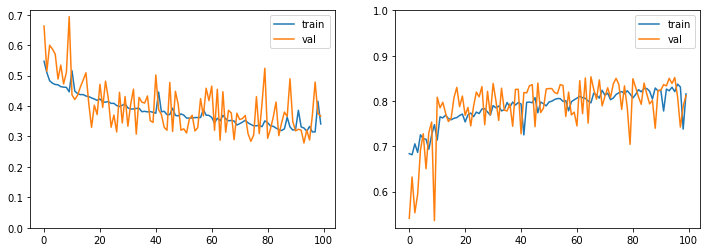

In [7]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6730 - accuracy: 0.5972 - precision: 0.7684 - recall: 0.6104 - f1: 0.6611 - specificity: 0.5629 - negative_predictive_value: 0.3994 - matthews_correlation_coefficient: 0.1704 - val_loss: 0.7034 - val_accuracy: 0.5629 - val_precision: 0.7943 - val_recall: 0.4638 - val_f1: 0.5783 - val_specificity: 0.7698 - val_negative_predictive_value: 0.4068 - val_matthews_correlation_coefficient: 0.2158

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21582, saving model to ../models/autoencoders_requirements/looking_away_2020_03_18-20_15_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6609 - accuracy: 0.6119 - precision: 0.7924 - recall: 0.6090 - f1: 0.6791 - specificity: 0.6367 - negative_predictive_value: 0.4214 - matthews_correlation_coefficient: 0.2281 - val_loss: 0.6545 - val_accuracy: 0.6236 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35880
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6246 - accuracy: 0.6570 - precision: 0.8183 - recall: 0.6549 - f1: 0.7178 - specificity: 0.6575 - negative_predictive_value: 0.4614 - matthews_correlation_coefficient: 0.2956 - val_loss: 0.5881 - val_accuracy: 0.6869 - val_precision: 0.7594 - val_recall: 0.7415 - val_f1: 0.7464 - val_specificity: 0.5269 - val_negative_predictive_value: 0.5040 - val_matthews_correlation_coefficient: 0.2646

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35880
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6169 - accuracy: 0.6690 - precision: 0.8201 - recall: 0.6750 - f1: 0.7323 - specificity: 0.6641 - negative_predictive_value: 0.4805 - matthews_correlation_coefficient: 0.3181 - val_loss: 0.5660 - val_accuracy: 0.7251 - val_precision: 0.7925 - val_recall: 0.7621 - val_f1: 0.7724 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5919 - accuracy: 0.6885 - precision: 0.8335 - recall: 0.6961 - f1: 0.7512 - specificity: 0.6836 - negative_predictive_value: 0.5055 - matthews_correlation_coefficient: 0.3570 - val_loss: 0.5851 - val_accuracy: 0.6834 - val_precision: 0.8296 - val_recall: 0.6382 - val_f1: 0.7159 - val_specificity: 0.7584 - val_negative_predictive_value: 0.5026 - val_matthews_correlation_coefficient: 0.3617

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37928
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5800 - accuracy: 0.6967 - precision: 0.8388 - recall: 0.7024 - f1: 0.7589 - specificity: 0.7003 - negative_predictive_value: 0.5126 - matthews_correlation_coefficient: 0.3748 - val_loss: 0.5798 - val_accuracy: 0.6852 - val_precision: 0.8282 - val_recall: 0.6391 - val_f1: 0.7171 - val_specificity: 0.7564 - val_negative_predictive_value: 0.5019 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.40432
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5707 - accuracy: 0.7113 - precision: 0.8384 - recall: 0.7151 - f1: 0.7643 - specificity: 0.6908 - negative_predictive_value: 0.5321 - matthews_correlation_coefficient: 0.3862 - val_loss: 0.6390 - val_accuracy: 0.6392 - val_precision: 0.8527 - val_recall: 0.5376 - val_f1: 0.6549 - val_specificity: 0.8385 - val_negative_predictive_value: 0.4638 - val_matthews_correlation_coefficient: 0.3431

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40432
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5688 - accuracy: 0.6996 - precision: 0.8446 - recall: 0.7005 - f1: 0.7570 - specificity: 0.7124 - negative_predictive_value: 0.5221 - matthews_correlation_coefficient: 0.3877 - val_loss: 0.5577 - val_accuracy: 0.7121 - val_precision: 0.8264 - val_recall: 0.6868 - val_f1: 0.7469 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5538 - accuracy: 0.7197 - precision: 0.8483 - recall: 0.7267 - f1: 0.7770 - specificity: 0.7058 - negative_predictive_value: 0.5363 - matthews_correlation_coefficient: 0.4081 - val_loss: 0.5410 - val_accuracy: 0.7337 - val_precision: 0.8340 - val_recall: 0.7171 - val_f1: 0.7673 - val_specificity: 0.7453 - val_negative_predictive_value: 0.5646 - val_matthews_correlation_coefficient: 0.4274

Epoch 00058: val_matthews_correlation_coefficient improved from 0.40960 to 0.42739, saving model to ../models/autoencoders_requirements/looking_away_2020_03_18-20_15_13.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5559 - accuracy: 0.7137 - precision: 0.8354 - recall: 0.7161 - f1: 0.7643 - specificity: 0.7013 - negative_predictive_value: 0.5341 - matthews_correlation_coefficient: 0.3926 - val_loss: 0.6432 - val_accuracy: 0.6600 - val_precision: 0.8454 - val_recall: 0.5843 - val_f1: 0.6849 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.42739
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5470 - accuracy: 0.7180 - precision: 0.8439 - recall: 0.7187 - f1: 0.7692 - specificity: 0.7127 - negative_predictive_value: 0.5361 - matthews_correlation_coefficient: 0.4101 - val_loss: 0.5994 - val_accuracy: 0.6774 - val_precision: 0.8399 - val_recall: 0.6225 - val_f1: 0.7099 - val_specificity: 0.7785 - val_negative_predictive_value: 0.4951 - val_matthews_correlation_coefficient: 0.3651

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.42739
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5525 - accuracy: 0.7111 - precision: 0.8554 - recall: 0.7033 - f1: 0.7643 - specificity: 0.7209 - negative_predictive_value: 0.5252 - matthews_correlation_coefficient: 0.4022 - val_loss: 0.5683 - val_accuracy: 0.6912 - val_precision: 0.8500 - val_recall: 0.6285 - val_f1: 0.7182 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.42739
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5390 - accuracy: 0.7297 - precision: 0.8591 - recall: 0.7361 - f1: 0.7874 - specificity: 0.7142 - negative_predictive_value: 0.5447 - matthews_correlation_coefficient: 0.4252 - val_loss: 0.5516 - val_accuracy: 0.7199 - val_precision: 0.8314 - val_recall: 0.7015 - val_f1: 0.7561 - val_specificity: 0.7275 - val_negative_predictive_value: 0.5422 - val_matthews_correlation_coefficient: 0.3992
Restoring model weights from the end of the best epoch

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.42739
Epoch 00088: early stopping

   Final Accuracy:  73.37%
  Final Precision:  85.86%
     Final Recall:  73.72%
  Final F-measure:  79.33%
Final Specificity:  72.60%
        Final NPV:  55.03%
        Final MCC:  43.52%
[[257  97]
 [210 589]]
              precision    recall  f1-score   support

           0     

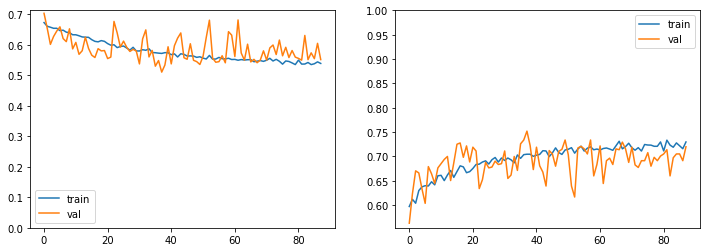

In [8]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [9]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one sample for one of the classes.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6267 - accuracy: 0.6547 - precision: 0.7921 - recall: 0.6731 - f1: 0.7021 - specificity: 0.6004 - negative_predictive_value: 0.5113 - matthews_correlation_coefficient: 0.2851 - val_loss: 0.6568 - val_accuracy: 0.6730 - val_precision: 0.7540 - val_recall: 0.7003 - val_f1: 0.7234 - val_specificity: 0.5694 - val_negative_predictive_value: 0.4986 - val_matthews_correlation_coefficient: 0.2603

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26034, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_18-20_28_15.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5880 - accuracy: 0.7102 - precision: 0.8100 - recall: 0.7587 - f1: 0.7751 - specificity: 0.6220 - negative_predictive_value: 0.5624 - matthews_correlation_coefficient: 0.3749 - val_loss: 0.5534 - val_accuracy: 0.7155 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4962 - accuracy: 0.7768 - precision: 0.8291 - recall: 0.8313 - f1: 0.8228 - specificity: 0.6568 - negative_predictive_value: 0.6865 - matthews_correlation_coefficient: 0.5001 - val_loss: 0.4570 - val_accuracy: 0.7918 - val_precision: 0.8135 - val_recall: 0.8395 - val_f1: 0.8240 - val_specificity: 0.6477 - val_negative_predictive_value: 0.6862 - val_matthews_correlation_coefficient: 0.4921

Epoch 00014: val_matthews_correlation_coefficient improved from 0.47257 to 0.49210, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_18-20_28_15.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4816 - accuracy: 0.7748 - precision: 0.8363 - recall: 0.8363 - f1: 0.8304 - specificity: 0.6491 - negative_predictive_value: 0.6539 - matthews_correlation_coefficient: 0.4875 - val_loss: 0.4683 - val_accuracy: 0.7806 - val_precision: 0.8114 - val_recall: 0.8237 - val_f1: 0.8150 - 


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.51377
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4590 - accuracy: 0.7937 - precision: 0.8380 - recall: 0.8536 - f1: 0.8414 - specificity: 0.6646 - negative_predictive_value: 0.6892 - matthews_correlation_coefficient: 0.5202 - val_loss: 0.5702 - val_accuracy: 0.7164 - val_precision: 0.8466 - val_recall: 0.6664 - val_f1: 0.7399 - val_specificity: 0.7820 - val_negative_predictive_value: 0.5563 - val_matthews_correlation_coefficient: 0.4240

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.51377
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4527 - accuracy: 0.7935 - precision: 0.8513 - recall: 0.8436 - f1: 0.8418 - specificity: 0.6927 - negative_predictive_value: 0.6837 - matthews_correlation_coefficient: 0.5352 - val_loss: 0.6020 - val_accuracy: 0.7034 - val_precision: 0.8242 - val_recall: 0.6629 - val_f1: 0.7295 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4280 - accuracy: 0.8015 - precision: 0.8545 - recall: 0.8417 - f1: 0.8447 - specificity: 0.6989 - negative_predictive_value: 0.6905 - matthews_correlation_coefficient: 0.5411 - val_loss: 0.5762 - val_accuracy: 0.6817 - val_precision: 0.8421 - val_recall: 0.6108 - val_f1: 0.7031 - val_specificity: 0.7972 - val_negative_predictive_value: 0.5150 - val_matthews_correlation_coefficient: 0.3806

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.55613
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4382 - accuracy: 0.7974 - precision: 0.8522 - recall: 0.8564 - f1: 0.8492 - specificity: 0.6859 - negative_predictive_value: 0.7086 - matthews_correlation_coefficient: 0.5482 - val_loss: 0.4570 - val_accuracy: 0.7762 - val_precision: 0.8573 - val_recall: 0.7569 - val_f1: 0.7986 - val_specificity: 0.7856 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4182 - accuracy: 0.8072 - precision: 0.8710 - recall: 0.8411 - f1: 0.8506 - specificity: 0.7332 - negative_predictive_value: 0.6972 - matthews_correlation_coefficient: 0.5707 - val_loss: 0.4614 - val_accuracy: 0.7832 - val_precision: 0.8207 - val_recall: 0.8146 - val_f1: 0.8148 - val_specificity: 0.6807 - val_negative_predictive_value: 0.6628 - val_matthews_correlation_coefficient: 0.4880

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.55613
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4039 - accuracy: 0.8167 - precision: 0.8759 - recall: 0.8543 - f1: 0.8605 - specificity: 0.7469 - negative_predictive_value: 0.7105 - matthews_correlation_coefficient: 0.5918 - val_loss: 0.5046 - val_accuracy: 0.7615 - val_precision: 0.8404 - val_recall: 0.7553 - val_f1: 0.7912 - val_specificity: 0.7166 - val_negative_predictive_value: 0.5925 - val_matthews_correlation_coefficie

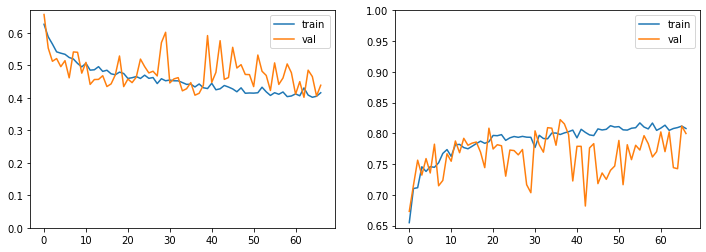

In [10]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5807 - accuracy: 0.7039 - precision: 0.9688 - recall: 0.7037 - f1: 0.7913 - specificity: 0.6708 - negative_predictive_value: 0.2323 - matthews_correlation_coefficient: 0.2751 - val_loss: 0.5796 - val_accuracy: 0.7069 - val_precision: 0.9606 - val_recall: 0.6714 - val_f1: 0.7865 - val_specificity: 0.8414 - val_negative_predictive_value: 0.2128 - val_matthews_correlation_coefficient: 0.2934

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29335, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_18-20_38_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4482 - accuracy: 0.8080 - precision: 0.9811 - recall: 0.8094 - f1: 0.8809 - specificity: 0.7824 - negative_predictive_value: 0.3003 - matthews_correlation_coefficient: 0.3978 - val_loss: 0.4712 - val_accuracy: 0.8049 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3511 - accuracy: 0.8672 - precision: 0.9837 - recall: 0.8722 - f1: 0.9230 - specificity: 0.7802 - negative_predictive_value: 0.3610 - matthews_correlation_coefficient: 0.4652 - val_loss: 0.3113 - val_accuracy: 0.8794 - val_precision: 0.9516 - val_recall: 0.8659 - val_f1: 0.9055 - val_specificity: 0.6979 - val_negative_predictive_value: 0.3555 - val_matthews_correlation_coefficient: 0.4047

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45502
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3406 - accuracy: 0.8679 - precision: 0.9859 - recall: 0.8668 - f1: 0.9202 - specificity: 0.8091 - negative_predictive_value: 0.3767 - matthews_correlation_coefficient: 0.4837 - val_loss: 0.2858 - val_accuracy: 0.8925 - val_precision: 0.9534 - val_recall: 0.8782 - val_f1: 0.9134 - val_specificity: 0.7272 - val_negative_predictive_value: 0.4101 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3244 - accuracy: 0.8683 - precision: 0.9852 - recall: 0.8711 - f1: 0.9229 - specificity: 0.7660 - negative_predictive_value: 0.3698 - matthews_correlation_coefficient: 0.4688 - val_loss: 0.4108 - val_accuracy: 0.8187 - val_precision: 0.9615 - val_recall: 0.7913 - val_f1: 0.8669 - val_specificity: 0.8286 - val_negative_predictive_value: 0.3066 - val_matthews_correlation_coefficient: 0.4001

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3131 - accuracy: 0.8766 - precision: 0.9871 - recall: 0.8792 - f1: 0.9286 - specificity: 0.7886 - negative_predictive_value: 0.3824 - matthews_correlation_coefficient: 0.4875 - val_loss: 0.3355 - val_accuracy: 0.8708 - val_precision: 0.9615 - val_recall: 0.8467 - val_f1: 0.8997 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2919 - accuracy: 0.8863 - precision: 0.9880 - recall: 0.8851 - f1: 0.9319 - specificity: 0.7941 - negative_predictive_value: 0.3995 - matthews_correlation_coefficient: 0.5048 - val_loss: 0.4452 - val_accuracy: 0.8075 - val_precision: 0.9635 - val_recall: 0.7772 - val_f1: 0.8589 - val_specificity: 0.8624 - val_negative_predictive_value: 0.2983 - val_matthews_correlation_coefficient: 0.3998

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2950 - accuracy: 0.8811 - precision: 0.9879 - recall: 0.8802 - f1: 0.9292 - specificity: 0.8083 - negative_predictive_value: 0.3826 - matthews_correlation_coefficient: 0.4980 - val_loss: 0.4574 - val_accuracy: 0.8153 - val_precision: 0.9672 - val_recall: 0.7830 - val_f1: 0.8640 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2718 - accuracy: 0.8909 - precision: 0.9893 - recall: 0.8919 - f1: 0.9366 - specificity: 0.8295 - negative_predictive_value: 0.4163 - matthews_correlation_coefficient: 0.5294 - val_loss: 0.2727 - val_accuracy: 0.8968 - val_precision: 0.9618 - val_recall: 0.8743 - val_f1: 0.9153 - val_specificity: 0.8196 - val_negative_predictive_value: 0.4281 - val_matthews_correlation_coefficient: 0.5094

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.51786
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2675 - accuracy: 0.8926 - precision: 0.9901 - recall: 0.8908 - f1: 0.9361 - specificity: 0.8655 - negative_predictive_value: 0.4258 - matthews_correlation_coefficient: 0.5498 - val_loss: 0.3473 - val_accuracy: 0.8647 - val_precision: 0.9623 - val_recall: 0.8399 - val_f1: 0.8959 - val_specificity: 0.8286 - val_negative_predictive_value: 0.3742 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2468 - accuracy: 0.8967 - precision: 0.9910 - recall: 0.8940 - f1: 0.9387 - specificity: 0.8248 - negative_predictive_value: 0.4215 - matthews_correlation_coefficient: 0.5378 - val_loss: 0.3825 - val_accuracy: 0.8413 - val_precision: 0.9631 - val_recall: 0.8143 - val_f1: 0.8813 - val_specificity: 0.8398 - val_negative_predictive_value: 0.3378 - val_matthews_correlation_coefficient: 0.4328

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.51786
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2751 - accuracy: 0.8846 - precision: 0.9898 - recall: 0.8857 - f1: 0.9330 - specificity: 0.8317 - negative_predictive_value: 0.4190 - matthews_correlation_coefficient: 0.5315 - val_loss: 0.3117 - val_accuracy: 0.8760 - val_precision: 0.9623 - val_recall: 0.8510 - val_f1: 0.9025 - val_specificity: 0.8466 - val_negative_predictive_value: 0.3816 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9020 - precision: 0.9916 - recall: 0.9022 - f1: 0.9436 - specificity: 0.8332 - negative_predictive_value: 0.4472 - matthews_correlation_coefficient: 0.5568 - val_loss: 0.3541 - val_accuracy: 0.8482 - val_precision: 0.9653 - val_recall: 0.8197 - val_f1: 0.8854 - val_specificity: 0.8759 - val_negative_predictive_value: 0.3482 - val_matthews_correlation_coefficient: 0.4556

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.56555
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2452 - accuracy: 0.8950 - precision: 0.9901 - recall: 0.8960 - f1: 0.9389 - specificity: 0.8600 - negative_predictive_value: 0.4475 - matthews_correlation_coefficient: 0.5596 - val_loss: 0.4287 - val_accuracy: 0.8326 - val_precision: 0.9649 - val_recall: 0.8028 - val_f1: 0.8754 - val_specificity: 0.8714 - val_negative_predictive_value: 0.3247 - val_matthews_correlation_coefficie

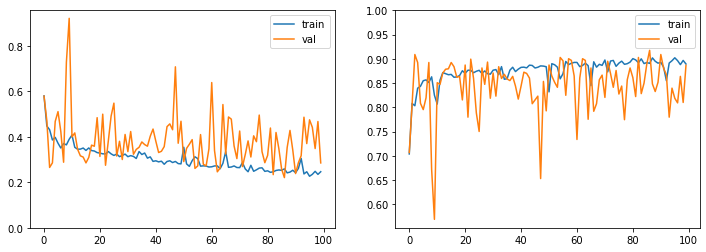

In [11]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5301 - accuracy: 0.7423 - precision: 0.9947 - recall: 0.7412 - f1: 0.8426 - specificity: 0.3218 - negative_predictive_value: 0.0489 - matthews_correlation_coefficient: 0.0957 - val_loss: 0.6821 - val_accuracy: 0.6513 - val_precision: 1.0000 - val_recall: 0.6553 - val_f1: 0.7871 - val_specificity: 0.4054 - val_negative_predictive_value: 0.0447 - val_matthews_correlation_coefficient: 0.1080

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10796, saving model to ../models/autoencoders_requirements/washed_out_2020_03_18-20_53_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4542 - accuracy: 0.7150 - precision: 0.9966 - recall: 0.7143 - f1: 0.8240 - specificity: 0.3241 - negative_predictive_value: 0.0390 - matthews_correlation_coefficient: 0.0848 - val_loss: 0.2515 - val_accuracy: 0.8621 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2555 - accuracy: 0.8254 - precision: 0.9980 - recall: 0.8257 - f1: 0.9006 - specificity: 0.3425 - negative_predictive_value: 0.0841 - matthews_correlation_coefficient: 0.1466 - val_loss: 0.2309 - val_accuracy: 0.8690 - val_precision: 0.9990 - val_recall: 0.8717 - val_f1: 0.9299 - val_specificity: 0.3919 - val_negative_predictive_value: 0.1158 - val_matthews_correlation_coefficient: 0.1959

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.24934
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2712 - accuracy: 0.8297 - precision: 0.9980 - recall: 0.8300 - f1: 0.9027 - specificity: 0.3816 - negative_predictive_value: 0.0965 - matthews_correlation_coefficient: 0.1641 - val_loss: 0.3063 - val_accuracy: 0.8101 - val_precision: 1.0000 - val_recall: 0.8122 - val_f1: 0.8947 - val_specificity: 0.4054 - val_negative_predictive_value: 0.0781 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2292 - accuracy: 0.8672 - precision: 0.9986 - recall: 0.8674 - f1: 0.9258 - specificity: 0.3862 - negative_predictive_value: 0.1207 - matthews_correlation_coefficient: 0.1913 - val_loss: 0.1563 - val_accuracy: 0.9358 - val_precision: 0.9982 - val_recall: 0.9386 - val_f1: 0.9668 - val_specificity: 0.3649 - val_negative_predictive_value: 0.2072 - val_matthews_correlation_coefficient: 0.2607

Epoch 00030: val_matthews_correlation_coefficient improved from 0.24934 to 0.26073, saving model to ../models/autoencoders_requirements/washed_out_2020_03_18-20_53_01.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2254 - accuracy: 0.8764 - precision: 0.9988 - recall: 0.8763 - f1: 0.9319 - specificity: 0.3621 - negative_predictive_value: 0.1328 - matthews_correlation_coefficient: 0.1965 - val_loss: 0.2247 - val_accuracy: 0.8734 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1: 0.9324 - val_speci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2553 - accuracy: 0.8835 - precision: 0.9979 - recall: 0.8813 - f1: 0.9326 - specificity: 0.3494 - negative_predictive_value: 0.1333 - matthews_correlation_coefficient: 0.1933 - val_loss: 0.2642 - val_accuracy: 0.8552 - val_precision: 1.0000 - val_recall: 0.8570 - val_f1: 0.9217 - val_specificity: 0.4054 - val_negative_predictive_value: 0.1103 - val_matthews_correlation_coefficient: 0.1947

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.30223
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1922 - accuracy: 0.8961 - precision: 0.9988 - recall: 0.8964 - f1: 0.9432 - specificity: 0.3943 - negative_predictive_value: 0.1584 - matthews_correlation_coefficient: 0.2256 - val_loss: 0.2347 - val_accuracy: 0.8742 - val_precision: 1.0000 - val_recall: 0.8759 - val_f1: 0.9328 - val_specificity: 0.4054 - val_negative_predictive_value: 0.1259 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1730 - accuracy: 0.9104 - precision: 0.9990 - recall: 0.9106 - f1: 0.9518 - specificity: 0.3690 - negative_predictive_value: 0.1490 - matthews_correlation_coefficient: 0.2179 - val_loss: 0.2270 - val_accuracy: 0.8864 - val_precision: 1.0000 - val_recall: 0.8879 - val_f1: 0.9395 - val_specificity: 0.4054 - val_negative_predictive_value: 0.1473 - val_matthews_correlation_coefficient: 0.2272

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.30223
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1562 - accuracy: 0.9132 - precision: 0.9991 - recall: 0.9134 - f1: 0.9532 - specificity: 0.3736 - negative_predictive_value: 0.1591 - matthews_correlation_coefficient: 0.2246 - val_loss: 0.2179 - val_accuracy: 0.8933 - val_precision: 1.0000 - val_recall: 0.8948 - val_f1: 0.9436 - val_specificity: 0.4054 - val_negative_predictive_value: 0.1532 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1570 - accuracy: 0.9213 - precision: 0.9989 - recall: 0.9217 - f1: 0.9577 - specificity: 0.3701 - negative_predictive_value: 0.1638 - matthews_correlation_coefficient: 0.2248 - val_loss: 0.1667 - val_accuracy: 0.9081 - val_precision: 0.9991 - val_recall: 0.9101 - val_f1: 0.9518 - val_specificity: 0.3784 - val_negative_predictive_value: 0.1446 - val_matthews_correlation_coefficient: 0.2177

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.31911
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1562 - accuracy: 0.9197 - precision: 0.9993 - recall: 0.9195 - f1: 0.9566 - specificity: 0.3655 - negative_predictive_value: 0.1552 - matthews_correlation_coefficient: 0.2215 - val_loss: 0.1426 - val_accuracy: 0.9402 - val_precision: 1.0000 - val_recall: 0.9413 - val_f1: 0.9693 - val_specificity: 0.4054 - val_negative_predictive_value: 0.2523 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.32314
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1534 - accuracy: 0.9167 - precision: 0.9993 - recall: 0.9168 - f1: 0.9551 - specificity: 0.3621 - negative_predictive_value: 0.1685 - matthews_correlation_coefficient: 0.2299 - val_loss: 0.2243 - val_accuracy: 0.8820 - val_precision: 0.9991 - val_recall: 0.8845 - val_f1: 0.9373 - val_specificity: 0.3784 - val_negative_predictive_value: 0.1203 - val_matthews_correlation_coefficient: 0.1978

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.32314
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1698 - accuracy: 0.9189 - precision: 0.9989 - recall: 0.9195 - f1: 0.9558 - specificity: 0.3391 - negative_predictive_value: 0.1824 - matthews_correlation_coefficient: 0.2329 - val_loss: 0.1613 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9179 - val_f1: 0.9567 - val_spe

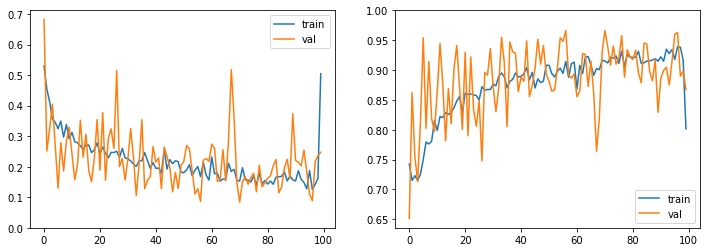

In [12]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6592 - accuracy: 0.5935 - precision: 0.9596 - recall: 0.5886 - f1: 0.7114 - specificity: 0.5868 - negative_predictive_value: 0.1108 - matthews_correlation_coefficient: 0.1251 - val_loss: 0.7265 - val_accuracy: 0.5100 - val_precision: 0.9424 - val_recall: 0.4769 - val_f1: 0.6275 - val_specificity: 0.6500 - val_negative_predictive_value: 0.0995 - val_matthews_correlation_coefficient: 0.1158

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11575, saving model to ../models/autoencoders_requirements/pixelation_2020_03_18-21_07_54.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6367 - accuracy: 0.6280 - precision: 0.9656 - recall: 0.6273 - f1: 0.7478 - specificity: 0.5879 - negative_predictive_value: 0.1319 - matthews_correlation_coefficient: 0.1550 - val_loss: 0.5584 - val_accuracy: 0.6800 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5405 - accuracy: 0.7228 - precision: 0.9757 - recall: 0.7237 - f1: 0.8254 - specificity: 0.6786 - negative_predictive_value: 0.1803 - matthews_correlation_coefficient: 0.2498 - val_loss: 0.3641 - val_accuracy: 0.8387 - val_precision: 0.9226 - val_recall: 0.8514 - val_f1: 0.8843 - val_specificity: 0.3077 - val_negative_predictive_value: 0.1664 - val_matthews_correlation_coefficient: 0.1461

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.20089
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5370 - accuracy: 0.7217 - precision: 0.9719 - recall: 0.7241 - f1: 0.8261 - specificity: 0.6533 - negative_predictive_value: 0.1664 - matthews_correlation_coefficient: 0.2295 - val_loss: 0.3381 - val_accuracy: 0.8413 - val_precision: 0.9228 - val_recall: 0.8543 - val_f1: 0.8860 - val_specificity: 0.3077 - val_negative_predictive_value: 0.1742 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.21098
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5206 - accuracy: 0.7425 - precision: 0.9701 - recall: 0.7377 - f1: 0.8347 - specificity: 0.7069 - negative_predictive_value: 0.1826 - matthews_correlation_coefficient: 0.2603 - val_loss: 0.4696 - val_accuracy: 0.7849 - val_precision: 0.9309 - val_recall: 0.7842 - val_f1: 0.8495 - val_specificity: 0.4198 - val_negative_predictive_value: 0.1480 - val_matthews_correlation_coefficient: 0.1578

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.21098
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5680 - accuracy: 0.7132 - precision: 0.9730 - recall: 0.7135 - f1: 0.8084 - specificity: 0.6406 - negative_predictive_value: 0.1923 - matthews_correlation_coefficient: 0.2378 - val_loss: 0.3358 - val_accuracy: 0.8690 - val_precision: 0.9201 - val_recall: 0.8878 - val_f1: 0.9025 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.21098
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5069 - accuracy: 0.7416 - precision: 0.9782 - recall: 0.7409 - f1: 0.8386 - specificity: 0.7237 - negative_predictive_value: 0.1869 - matthews_correlation_coefficient: 0.2741 - val_loss: 0.3207 - val_accuracy: 0.8361 - val_precision: 0.9244 - val_recall: 0.8470 - val_f1: 0.8827 - val_specificity: 0.3468 - val_negative_predictive_value: 0.1710 - val_matthews_correlation_coefficient: 0.1603

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.21098
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5052 - accuracy: 0.7447 - precision: 0.9740 - recall: 0.7454 - f1: 0.8397 - specificity: 0.6764 - negative_predictive_value: 0.1796 - matthews_correlation_coefficient: 0.2595 - val_loss: 0.4869 - val_accuracy: 0.7251 - val_precision: 0.9408 - val_recall: 0.7108 - val_f1: 0.8075 - val_spe

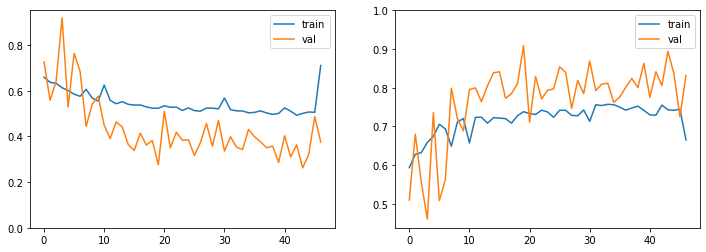

In [13]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5830 - accuracy: 0.6798 - precision: 0.9327 - recall: 0.6592 - f1: 0.7632 - specificity: 0.7541 - negative_predictive_value: 0.3221 - matthews_correlation_coefficient: 0.3272 - val_loss: 0.5473 - val_accuracy: 0.6670 - val_precision: 0.9475 - val_recall: 0.6387 - val_f1: 0.7584 - val_specificity: 0.8308 - val_negative_predictive_value: 0.3307 - val_matthews_correlation_coefficient: 0.3584

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35843, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_18-21_14_58.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5637 - accuracy: 0.6792 - precision: 0.9436 - recall: 0.6462 - f1: 0.7629 - specificity: 0.8155 - negative_predictive_value: 0.3411 - matthews_correlation_coefficient: 0.3592 - val_loss: 0.6442 - val_accuracy: 0.6626 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5301 - accuracy: 0.7232 - precision: 0.9420 - recall: 0.7078 - f1: 0.8026 - specificity: 0.7973 - negative_predictive_value: 0.3852 - matthews_correlation_coefficient: 0.4007 - val_loss: 0.4607 - val_accuracy: 0.7398 - val_precision: 0.9370 - val_recall: 0.7425 - val_f1: 0.8246 - val_specificity: 0.7577 - val_negative_predictive_value: 0.3897 - val_matthews_correlation_coefficient: 0.4004

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40911
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5206 - accuracy: 0.7195 - precision: 0.9427 - recall: 0.7000 - f1: 0.7991 - specificity: 0.8068 - negative_predictive_value: 0.3781 - matthews_correlation_coefficient: 0.3991 - val_loss: 0.5568 - val_accuracy: 0.6921 - val_precision: 0.9441 - val_recall: 0.6741 - val_f1: 0.7828 - val_specificity: 0.8047 - val_negative_predictive_value: 0.3456 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5138 - accuracy: 0.7280 - precision: 0.9417 - recall: 0.7171 - f1: 0.8070 - specificity: 0.7827 - negative_predictive_value: 0.3916 - matthews_correlation_coefficient: 0.4048 - val_loss: 0.5228 - val_accuracy: 0.7207 - val_precision: 0.9464 - val_recall: 0.7089 - val_f1: 0.8068 - val_specificity: 0.8058 - val_negative_predictive_value: 0.3751 - val_matthews_correlation_coefficient: 0.4033

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.42066
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5022 - accuracy: 0.7401 - precision: 0.9399 - recall: 0.7323 - f1: 0.8185 - specificity: 0.7791 - negative_predictive_value: 0.3981 - matthews_correlation_coefficient: 0.4100 - val_loss: 0.4904 - val_accuracy: 0.7329 - val_precision: 0.9390 - val_recall: 0.7296 - val_f1: 0.8181 - val_specificity: 0.7722 - val_negative_predictive_value: 0.3798 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4904 - accuracy: 0.7488 - precision: 0.9418 - recall: 0.7411 - f1: 0.8248 - specificity: 0.7981 - negative_predictive_value: 0.4119 - matthews_correlation_coefficient: 0.4316 - val_loss: 0.4903 - val_accuracy: 0.7485 - val_precision: 0.9409 - val_recall: 0.7485 - val_f1: 0.8304 - val_specificity: 0.7735 - val_negative_predictive_value: 0.3989 - val_matthews_correlation_coefficient: 0.4174

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42066
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4846 - accuracy: 0.7469 - precision: 0.9436 - recall: 0.7371 - f1: 0.8224 - specificity: 0.7957 - negative_predictive_value: 0.4133 - matthews_correlation_coefficient: 0.4320 - val_loss: 0.5332 - val_accuracy: 0.7042 - val_precision: 0.9505 - val_recall: 0.6841 - val_f1: 0.7918 - val_specificity: 0.8219 - val_negative_predictive_value: 0.3569 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.46363
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4773 - accuracy: 0.7382 - precision: 0.9451 - recall: 0.7205 - f1: 0.8121 - specificity: 0.8060 - negative_predictive_value: 0.4002 - matthews_correlation_coefficient: 0.4237 - val_loss: 0.5053 - val_accuracy: 0.7320 - val_precision: 0.9476 - val_recall: 0.7219 - val_f1: 0.8159 - val_specificity: 0.7962 - val_negative_predictive_value: 0.3844 - val_matthews_correlation_coefficient: 0.4118

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46363
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4762 - accuracy: 0.7551 - precision: 0.9414 - recall: 0.7503 - f1: 0.8295 - specificity: 0.7928 - negative_predictive_value: 0.4320 - matthews_correlation_coefficient: 0.4436 - val_loss: 0.5326 - val_accuracy: 0.7069 - val_precision: 0.9498 - val_recall: 0.6866 - val_f1: 0.7937 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.46363
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4605 - accuracy: 0.7594 - precision: 0.9472 - recall: 0.7510 - f1: 0.8329 - specificity: 0.7937 - negative_predictive_value: 0.4213 - matthews_correlation_coefficient: 0.4440 - val_loss: 0.4603 - val_accuracy: 0.7641 - val_precision: 0.9438 - val_recall: 0.7646 - val_f1: 0.8419 - val_specificity: 0.7774 - val_negative_predictive_value: 0.4163 - val_matthews_correlation_coefficient: 0.4383

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46363
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4619 - accuracy: 0.7616 - precision: 0.9434 - recall: 0.7527 - f1: 0.8332 - specificity: 0.7879 - negative_predictive_value: 0.4274 - matthews_correlation_coefficient: 0.4448 - val_loss: 0.5034 - val_accuracy: 0.7389 - val_precision: 0.9553 - val_recall: 0.7235 - val_f1: 0.8202 - val_spe

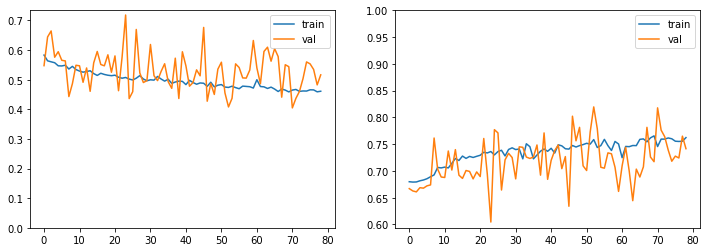

In [14]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6353 - accuracy: 0.5371 - precision: 0.9060 - recall: 0.4688 - f1: 0.6037 - specificity: 0.7981 - negative_predictive_value: 0.2745 - matthews_correlation_coefficient: 0.2206 - val_loss: 0.5564 - val_accuracy: 0.6739 - val_precision: 0.8530 - val_recall: 0.7274 - val_f1: 0.7801 - val_specificity: 0.5002 - val_negative_predictive_value: 0.3220 - val_matthews_correlation_coefficient: 0.1983

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19834, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_18-21_26_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6340 - accuracy: 0.5471 - precision: 0.9148 - recall: 0.4801 - f1: 0.6165 - specificity: 0.8153 - negative_predictive_value: 0.2925 - matthews_correlation_coefficient: 0.2450 - val_loss: 0.7098 - val_accuracy: 0.4918 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5836 - accuracy: 0.6473 - precision: 0.9220 - recall: 0.6092 - f1: 0.7227 - specificity: 0.7894 - negative_predictive_value: 0.3522 - matthews_correlation_coefficient: 0.3287 - val_loss: 0.5200 - val_accuracy: 0.7095 - val_precision: 0.8763 - val_recall: 0.7486 - val_f1: 0.8036 - val_specificity: 0.5751 - val_negative_predictive_value: 0.3719 - val_matthews_correlation_coefficient: 0.2810

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36443
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5862 - accuracy: 0.6445 - precision: 0.9190 - recall: 0.6140 - f1: 0.7253 - specificity: 0.7810 - negative_predictive_value: 0.3516 - matthews_correlation_coefficient: 0.3218 - val_loss: 0.5301 - val_accuracy: 0.6982 - val_precision: 0.8957 - val_recall: 0.7122 - val_f1: 0.7895 - val_specificity: 0.6614 - val_negative_predictive_value: 0.3716 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.37685
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5419 - accuracy: 0.6935 - precision: 0.9230 - recall: 0.6699 - f1: 0.7709 - specificity: 0.7728 - negative_predictive_value: 0.3805 - matthews_correlation_coefficient: 0.3645 - val_loss: 0.6306 - val_accuracy: 0.6609 - val_precision: 0.9012 - val_recall: 0.6554 - val_f1: 0.7554 - val_specificity: 0.6997 - val_negative_predictive_value: 0.3382 - val_matthews_correlation_coefficient: 0.2902

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37685
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5434 - accuracy: 0.6885 - precision: 0.9162 - recall: 0.6611 - f1: 0.7621 - specificity: 0.7803 - negative_predictive_value: 0.3798 - matthews_correlation_coefficient: 0.3654 - val_loss: 0.4994 - val_accuracy: 0.7407 - val_precision: 0.9049 - val_recall: 0.7639 - val_f1: 0.8254 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5347 - accuracy: 0.6866 - precision: 0.9258 - recall: 0.6599 - f1: 0.7635 - specificity: 0.7920 - negative_predictive_value: 0.3831 - matthews_correlation_coefficient: 0.3718 - val_loss: 0.5619 - val_accuracy: 0.6860 - val_precision: 0.9263 - val_recall: 0.6665 - val_f1: 0.7716 - val_specificity: 0.7736 - val_negative_predictive_value: 0.3703 - val_matthews_correlation_coefficient: 0.3597

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38291
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5232 - accuracy: 0.7052 - precision: 0.9237 - recall: 0.6860 - f1: 0.7826 - specificity: 0.7772 - negative_predictive_value: 0.3941 - matthews_correlation_coefficient: 0.3819 - val_loss: 0.5621 - val_accuracy: 0.6592 - val_precision: 0.9366 - val_recall: 0.6196 - val_f1: 0.7406 - val_specificity: 0.8245 - val_negative_predictive_value: 0.3557 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5187 - accuracy: 0.7056 - precision: 0.9264 - recall: 0.6878 - f1: 0.7814 - specificity: 0.7955 - negative_predictive_value: 0.4003 - matthews_correlation_coefficient: 0.3959 - val_loss: 0.4858 - val_accuracy: 0.7372 - val_precision: 0.9087 - val_recall: 0.7519 - val_f1: 0.8199 - val_specificity: 0.6926 - val_negative_predictive_value: 0.4206 - val_matthews_correlation_coefficient: 0.3804

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41587
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5309 - accuracy: 0.6798 - precision: 0.9325 - recall: 0.6465 - f1: 0.7558 - specificity: 0.8068 - negative_predictive_value: 0.3768 - matthews_correlation_coefficient: 0.3724 - val_loss: 0.5281 - val_accuracy: 0.6982 - val_precision: 0.9245 - val_recall: 0.6842 - val_f1: 0.7830 - val_specificity: 0.7706 - val_negative_predictive_value: 0.3830 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5056 - accuracy: 0.7102 - precision: 0.9309 - recall: 0.6879 - f1: 0.7855 - specificity: 0.7839 - negative_predictive_value: 0.3988 - matthews_correlation_coefficient: 0.3919 - val_loss: 0.4456 - val_accuracy: 0.7632 - val_precision: 0.9088 - val_recall: 0.7896 - val_f1: 0.8421 - val_specificity: 0.6742 - val_negative_predictive_value: 0.4486 - val_matthews_correlation_coefficient: 0.4050

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.41587
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5178 - accuracy: 0.7061 - precision: 0.9321 - recall: 0.6824 - f1: 0.7809 - specificity: 0.7876 - negative_predictive_value: 0.3966 - matthews_correlation_coefficient: 0.3906 - val_loss: 0.4942 - val_accuracy: 0.7259 - val_precision: 0.9256 - val_recall: 0.7214 - val_f1: 0.8076 - val_specificity: 0.7550 - val_negative_predictive_value: 0.4077 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.41587
Epoch 00086: early stopping

   Final Accuracy:  75.02%
  Final Precision:  91.84%
     Final Recall:  75.16%
  Final F-measure:  82.67%
Final Specificity:  74.48%
        Final NPV:  43.95%
        Final MCC:  42.15%
[[178  61]
 [227 687]]
              precision    recall  f1-score   support

           0       0.44      0.74      0.55       239
           1       0.92      0.75      0.83       914

    accuracy                           0.75      1153
   macro avg       0.68      0.75      0.69      1153
weighted avg       0.82      0.75      0.77      1153



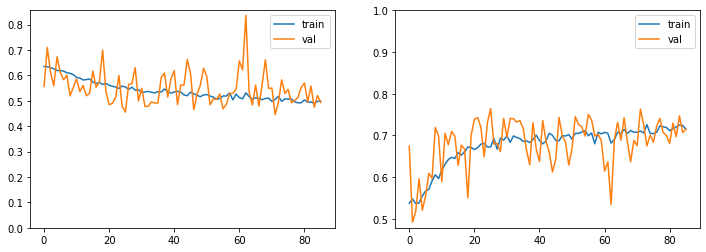

In [15]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5089 - accuracy: 0.7295 - precision: 0.8015 - recall: 0.7023 - f1: 0.7207 - specificity: 0.7680 - negative_predictive_value: 0.7041 - matthews_correlation_coefficient: 0.4917 - val_loss: 0.4056 - val_accuracy: 0.7927 - val_precision: 0.7349 - val_recall: 0.9045 - val_f1: 0.8071 - val_specificity: 0.6269 - val_negative_predictive_value: 0.8742 - val_matthews_correlation_coefficient: 0.5671

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.56708, saving model to ../models/autoencoders_requirements/varied_background_2020_03_18-21_39_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4305 - accuracy: 0.7805 - precision: 0.8271 - recall: 0.7730 - f1: 0.7850 - specificity: 0.7916 - negative_predictive_value: 0.7570 - matthews_correlation_coefficient: 0.5735 - val_loss: 0.4078 - val_accuracy: 0.7710 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3447 - accuracy: 0.8304 - precision: 0.8663 - recall: 0.8286 - f1: 0.8413 - specificity: 0.8379 - negative_predictive_value: 0.7980 - matthews_correlation_coefficient: 0.6649 - val_loss: 0.3140 - val_accuracy: 0.8343 - val_precision: 0.8766 - val_recall: 0.7700 - val_f1: 0.8142 - val_specificity: 0.8981 - val_negative_predictive_value: 0.7798 - val_matthews_correlation_coefficient: 0.6618

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.67120
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3353 - accuracy: 0.8356 - precision: 0.8762 - recall: 0.8305 - f1: 0.8458 - specificity: 0.8521 - negative_predictive_value: 0.8024 - matthews_correlation_coefficient: 0.6801 - val_loss: 0.3411 - val_accuracy: 0.8231 - val_precision: 0.7601 - val_recall: 0.9270 - val_f1: 0.8315 - val_specificity: 0.6688 - val_negative_predictive_value: 0.9089 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69484
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3205 - accuracy: 0.8416 - precision: 0.8716 - recall: 0.8332 - f1: 0.8461 - specificity: 0.8535 - negative_predictive_value: 0.8094 - matthews_correlation_coefficient: 0.6833 - val_loss: 0.2939 - val_accuracy: 0.8612 - val_precision: 0.8701 - val_recall: 0.8309 - val_f1: 0.8455 - val_specificity: 0.8784 - val_negative_predictive_value: 0.8291 - val_matthews_correlation_coefficient: 0.7040

Epoch 00030: val_matthews_correlation_coefficient improved from 0.69484 to 0.70400, saving model to ../models/autoencoders_requirements/varied_background_2020_03_18-21_39_35.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3153 - accuracy: 0.8495 - precision: 0.8872 - recall: 0.8436 - f1: 0.8596 - specificity: 0.8603 - negative_predictive_value: 0.8176 - matthews_correlation_coefficient: 0.7040 - val_loss: 0.2

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2980 - accuracy: 0.8560 - precision: 0.8854 - recall: 0.8564 - f1: 0.8666 - specificity: 0.8625 - negative_predictive_value: 0.8251 - matthews_correlation_coefficient: 0.7144 - val_loss: 0.2828 - val_accuracy: 0.8482 - val_precision: 0.8615 - val_recall: 0.8151 - val_f1: 0.8339 - val_specificity: 0.8717 - val_negative_predictive_value: 0.8108 - val_matthews_correlation_coefficient: 0.6792

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.72272
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3010 - accuracy: 0.8562 - precision: 0.8877 - recall: 0.8524 - f1: 0.8645 - specificity: 0.8577 - negative_predictive_value: 0.8196 - matthews_correlation_coefficient: 0.7101 - val_loss: 0.2770 - val_accuracy: 0.8621 - val_precision: 0.8677 - val_recall: 0.8352 - val_f1: 0.8472 - val_specificity: 0.8743 - val_negative_predictive_value: 0.8337 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73124
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2846 - accuracy: 0.8607 - precision: 0.8940 - recall: 0.8578 - f1: 0.8693 - specificity: 0.8701 - negative_predictive_value: 0.8214 - matthews_correlation_coefficient: 0.7231 - val_loss: 0.2631 - val_accuracy: 0.8708 - val_precision: 0.8701 - val_recall: 0.8496 - val_f1: 0.8562 - val_specificity: 0.8742 - val_negative_predictive_value: 0.8476 - val_matthews_correlation_coefficient: 0.7203

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.73124
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2891 - accuracy: 0.8616 - precision: 0.8845 - recall: 0.8536 - f1: 0.8642 - specificity: 0.8611 - negative_predictive_value: 0.8273 - matthews_correlation_coefficient: 0.7130 - val_loss: 0.2790 - val_accuracy: 0.8543 - val_precision: 0.8766 - val_recall: 0.8095 - val_f1: 0.8380 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73425
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2730 - accuracy: 0.8690 - precision: 0.9002 - recall: 0.8671 - f1: 0.8785 - specificity: 0.8755 - negative_predictive_value: 0.8406 - matthews_correlation_coefficient: 0.7414 - val_loss: 0.2528 - val_accuracy: 0.8812 - val_precision: 0.8392 - val_recall: 0.9089 - val_f1: 0.8699 - val_specificity: 0.8213 - val_negative_predictive_value: 0.9075 - val_matthews_correlation_coefficient: 0.7378

Epoch 00074: val_matthews_correlation_coefficient improved from 0.73425 to 0.73781, saving model to ../models/autoencoders_requirements/varied_background_2020_03_18-21_39_35.h5
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2718 - accuracy: 0.8692 - precision: 0.8949 - recall: 0.8592 - f1: 0.8730 - specificity: 0.8784 - negative_predictive_value: 0.8347 - matthews_correlation_coefficient: 0.7351 - val_loss: 0.2

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2657 - accuracy: 0.8709 - precision: 0.8979 - recall: 0.8616 - f1: 0.8736 - specificity: 0.8802 - negative_predictive_value: 0.8354 - matthews_correlation_coefficient: 0.7442 - val_loss: 0.2551 - val_accuracy: 0.8829 - val_precision: 0.8491 - val_recall: 0.8993 - val_f1: 0.8702 - val_specificity: 0.8378 - val_negative_predictive_value: 0.9008 - val_matthews_correlation_coefficient: 0.7431

Epoch 00088: val_matthews_correlation_coefficient improved from 0.73812 to 0.74310, saving model to ../models/autoencoders_requirements/varied_background_2020_03_18-21_39_35.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2876 - accuracy: 0.8555 - precision: 0.8833 - recall: 0.8470 - f1: 0.8578 - specificity: 0.8692 - negative_predictive_value: 0.8242 - matthews_correlation_coefficient: 0.7131 - val_loss: 0.2707 - val_accuracy: 0.8682 - val_precision: 0.8409 - val_recall: 0.8782 - val_f1: 0.8556 - va

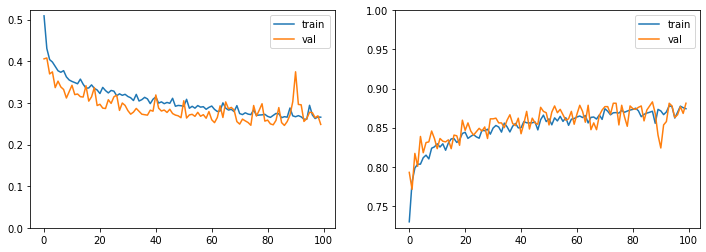

In [16]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6170 - accuracy: 0.6868 - precision: 0.8396 - recall: 0.6849 - f1: 0.7476 - specificity: 0.6876 - negative_predictive_value: 0.4660 - matthews_correlation_coefficient: 0.3410 - val_loss: 0.6593 - val_accuracy: 0.6435 - val_precision: 0.8779 - val_recall: 0.5864 - val_f1: 0.6964 - val_specificity: 0.7885 - val_negative_predictive_value: 0.4286 - val_matthews_correlation_coefficient: 0.3374

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33743, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_18-21_54_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6124 - accuracy: 0.6768 - precision: 0.8557 - recall: 0.6631 - f1: 0.7378 - specificity: 0.7190 - negative_predictive_value: 0.4660 - matthews_correlation_coefficient: 0.3488 - val_loss: 0.5497 - val_accuracy: 0.6860 - val_precisi


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37088
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5968 - accuracy: 0.6954 - precision: 0.8576 - recall: 0.6843 - f1: 0.7566 - specificity: 0.7322 - negative_predictive_value: 0.4833 - matthews_correlation_coefficient: 0.3770 - val_loss: 0.6043 - val_accuracy: 0.6869 - val_precision: 0.8653 - val_recall: 0.6671 - val_f1: 0.7481 - val_specificity: 0.7334 - val_negative_predictive_value: 0.4649 - val_matthews_correlation_coefficient: 0.3621

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37088
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5965 - accuracy: 0.6959 - precision: 0.8518 - recall: 0.6816 - f1: 0.7534 - specificity: 0.7282 - negative_predictive_value: 0.4894 - matthews_correlation_coefficient: 0.3738 - val_loss: 0.6110 - val_accuracy: 0.6878 - val_precision: 0.8738 - val_recall: 0.6590 - val_f1: 0.7460 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37287
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5897 - accuracy: 0.6944 - precision: 0.8617 - recall: 0.6826 - f1: 0.7578 - specificity: 0.7255 - negative_predictive_value: 0.4798 - matthews_correlation_coefficient: 0.3722 - val_loss: 0.6042 - val_accuracy: 0.6834 - val_precision: 0.8734 - val_recall: 0.6527 - val_f1: 0.7418 - val_specificity: 0.7548 - val_negative_predictive_value: 0.4606 - val_matthews_correlation_coefficient: 0.3675

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37287
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5882 - accuracy: 0.6983 - precision: 0.8638 - recall: 0.6876 - f1: 0.7610 - specificity: 0.7450 - negative_predictive_value: 0.4968 - matthews_correlation_coefficient: 0.3933 - val_loss: 0.6103 - val_accuracy: 0.6878 - val_precision: 0.8694 - val_recall: 0.6631 - val_f1: 0.7474 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37631
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5882 - accuracy: 0.6965 - precision: 0.8680 - recall: 0.6742 - f1: 0.7543 - specificity: 0.7397 - negative_predictive_value: 0.4808 - matthews_correlation_coefficient: 0.3802 - val_loss: 0.5834 - val_accuracy: 0.6912 - val_precision: 0.8678 - val_recall: 0.6702 - val_f1: 0.7509 - val_specificity: 0.7386 - val_negative_predictive_value: 0.4692 - val_matthews_correlation_coefficient: 0.3696

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.37631
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5839 - accuracy: 0.6970 - precision: 0.8676 - recall: 0.6820 - f1: 0.7597 - specificity: 0.7464 - negative_predictive_value: 0.4880 - matthews_correlation_coefficient: 0.3881 - val_loss: 0.5638 - val_accuracy: 0.6878 - val_precision: 0.8544 - val_recall: 0.6814 - val_f1: 0.7530 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38121
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5818 - accuracy: 0.6996 - precision: 0.8708 - recall: 0.6812 - f1: 0.7601 - specificity: 0.7509 - negative_predictive_value: 0.4871 - matthews_correlation_coefficient: 0.3913 - val_loss: 0.6013 - val_accuracy: 0.6982 - val_precision: 0.8706 - val_recall: 0.6816 - val_f1: 0.7594 - val_specificity: 0.7349 - val_negative_predictive_value: 0.4745 - val_matthews_correlation_coefficient: 0.3776

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.38121
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5794 - accuracy: 0.7024 - precision: 0.8601 - recall: 0.6815 - f1: 0.7570 - specificity: 0.7449 - negative_predictive_value: 0.4957 - matthews_correlation_coefficient: 0.3899 - val_loss: 0.6005 - val_accuracy: 0.6878 - val_precision: 0.8740 - val_recall: 0.6565 - val_f1: 0.7455 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5757 - accuracy: 0.6996 - precision: 0.8697 - recall: 0.6831 - f1: 0.7604 - specificity: 0.7569 - negative_predictive_value: 0.4973 - matthews_correlation_coefficient: 0.4002 - val_loss: 0.5923 - val_accuracy: 0.6826 - val_precision: 0.8787 - val_recall: 0.6457 - val_f1: 0.7385 - val_specificity: 0.7622 - val_negative_predictive_value: 0.4581 - val_matthews_correlation_coefficient: 0.3689 0.6840 - f1: 0.7607 - specificity: 0.7490 - negative_predictive_value: 0.4952 - matthews_corre

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.38121
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5783 - accuracy: 0.6939 - precision: 0.8728 - recall: 0.6700 - f1: 0.7539 - specificity: 0.7560 - negative_predictive_value: 0.4798 - matthews_correlation_coefficient: 0.3861 - val_loss: 0.5756 - val_accuracy: 0.6990 - val_precision: 0.8666 - val_recall: 0.6877 - val_f1: 0.7617 - val_s


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.38189
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5708 - accuracy: 0.6987 - precision: 0.8743 - recall: 0.6741 - f1: 0.7567 - specificity: 0.7630 - negative_predictive_value: 0.4859 - matthews_correlation_coefficient: 0.3953 - val_loss: 0.5509 - val_accuracy: 0.6938 - val_precision: 0.8544 - val_recall: 0.6890 - val_f1: 0.7582 - val_specificity: 0.7009 - val_negative_predictive_value: 0.4700 - val_matthews_correlation_coefficient: 0.3543

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.38189
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5736 - accuracy: 0.6944 - precision: 0.8738 - recall: 0.6669 - f1: 0.7517 - specificity: 0.7648 - negative_predictive_value: 0.4820 - matthews_correlation_coefficient: 0.3900 - val_loss: 0.5547 - val_accuracy: 0.7042 - val_precision: 0.8585 - val_recall: 0.7048 - val_f1: 0.7697 - val_spe

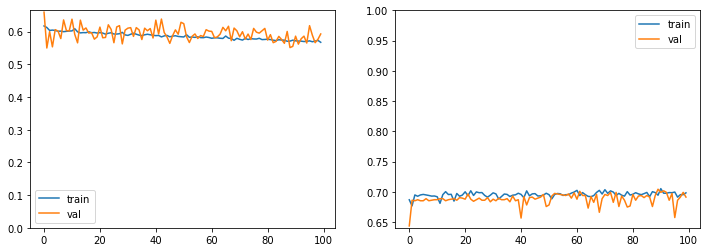

In [17]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6106 - accuracy: 0.6844 - precision: 0.6984 - recall: 0.5820 - f1: 0.6092 - specificity: 0.7670 - negative_predictive_value: 0.6877 - matthews_correlation_coefficient: 0.3675 - val_loss: 0.5890 - val_accuracy: 0.7042 - val_precision: 0.6327 - val_recall: 0.7397 - val_f1: 0.6725 - val_specificity: 0.6411 - val_negative_predictive_value: 0.7507 - val_matthews_correlation_coefficient: 0.4085

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40852, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_18-22_09_19.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5611 - accuracy: 0.7388 - precision: 0.7415 - recall: 0.6665 - f1: 0.6866 - specificity: 0.7997 - negative_predictive_value: 0.7525 - matthews_correlation_coefficient: 0.4792 - val_loss: 0.5306 - val_accuracy: 0.7554 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4783 - accuracy: 0.7785 - precision: 0.7798 - recall: 0.7292 - f1: 0.7450 - specificity: 0.8252 - negative_predictive_value: 0.7848 - matthews_correlation_coefficient: 0.5590 - val_loss: 0.4867 - val_accuracy: 0.7710 - val_precision: 0.8139 - val_recall: 0.6018 - val_f1: 0.6854 - val_specificity: 0.8767 - val_negative_predictive_value: 0.7172 - val_matthews_correlation_coefficient: 0.5305

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55138
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4807 - accuracy: 0.7811 - precision: 0.7743 - recall: 0.7223 - f1: 0.7399 - specificity: 0.8312 - negative_predictive_value: 0.7835 - matthews_correlation_coefficient: 0.5570 - val_loss: 0.4755 - val_accuracy: 0.7797 - val_precision: 0.8070 - val_recall: 0.6326 - val_f1: 0.7026 - val_specificity: 0.8657 - val_negative_predictive_value: 0.7312 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient improved from 0.56581 to 0.57020, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_18-22_09_19.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4550 - accuracy: 0.7907 - precision: 0.7895 - recall: 0.7360 - f1: 0.7542 - specificity: 0.8338 - negative_predictive_value: 0.7883 - matthews_correlation_coefficient: 0.5735 - val_loss: 0.4738 - val_accuracy: 0.7762 - val_precision: 0.7654 - val_recall: 0.7458 - val_f1: 0.7482 - val_specificity: 0.7867 - val_negative_predictive_value: 0.7669 - val_matthews_correlation_coefficient: 0.5322

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57020
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4582 - accuracy: 0.7846 - precision: 0.7700 - recall: 0.7316 - f1: 0.7431 - specificity: 0.8266 - negative_predictive_value: 0.7921 - matthews_correlation_coefficient: 0.5598 - val_lo

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4345 - accuracy: 0.8043 - precision: 0.8002 - recall: 0.7611 - f1: 0.7733 - specificity: 0.8332 - negative_predictive_value: 0.8049 - matthews_correlation_coefficient: 0.6011 - val_loss: 0.5219 - val_accuracy: 0.7598 - val_precision: 0.6816 - val_recall: 0.7994 - val_f1: 0.7288 - val_specificity: 0.6903 - val_negative_predictive_value: 0.8049 - val_matthews_correlation_coefficient: 0.5146

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58171
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4402 - accuracy: 0.7989 - precision: 0.7852 - recall: 0.7604 - f1: 0.7638 - specificity: 0.8302 - negative_predictive_value: 0.8150 - matthews_correlation_coefficient: 0.5948 - val_loss: 0.4682 - val_accuracy: 0.7918 - val_precision: 0.8068 - val_recall: 0.6681 - val_f1: 0.7249 - val_specificity: 0.8604 - val_negative_predictive_value: 0.7480 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.58171
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4254 - accuracy: 0.8061 - precision: 0.7874 - recall: 0.7708 - f1: 0.7715 - specificity: 0.8309 - negative_predictive_value: 0.8194 - matthews_correlation_coefficient: 0.6056 - val_loss: 0.4646 - val_accuracy: 0.8014 - val_precision: 0.8071 - val_recall: 0.6891 - val_f1: 0.7366 - val_specificity: 0.8578 - val_negative_predictive_value: 0.7623 - val_matthews_correlation_coefficient: 0.5846

Epoch 00058: val_matthews_correlation_coefficient improved from 0.58171 to 0.58460, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_18-22_09_19.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4250 - accuracy: 0.8056 - precision: 0.8017 - recall: 0.7695 - f1: 0.7777 - specificity: 0.8424 - negative_predictive_value: 0.8140 - matthews_correlation_coefficient: 0.6134 - val_lo


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.58460
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4072 - accuracy: 0.8189 - precision: 0.8106 - recall: 0.7883 - f1: 0.7916 - specificity: 0.8425 - negative_predictive_value: 0.8255 - matthews_correlation_coefficient: 0.6331 - val_loss: 0.4826 - val_accuracy: 0.7780 - val_precision: 0.7186 - val_recall: 0.7570 - val_f1: 0.7320 - val_specificity: 0.7572 - val_negative_predictive_value: 0.7873 - val_matthews_correlation_coefficient: 0.5368

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.58460
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4111 - accuracy: 0.8154 - precision: 0.8025 - recall: 0.7891 - f1: 0.7882 - specificity: 0.8396 - negative_predictive_value: 0.8315 - matthews_correlation_coefficient: 0.6310 - val_loss: 0.4651 - val_accuracy: 0.7944 - val_precision: 0.7914 - val_recall: 0.6877 - val_f1: 0.7300 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.58883
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4015 - accuracy: 0.8184 - precision: 0.8123 - recall: 0.7884 - f1: 0.7923 - specificity: 0.8386 - negative_predictive_value: 0.8251 - matthews_correlation_coefficient: 0.6336 - val_loss: 0.4711 - val_accuracy: 0.7875 - val_precision: 0.7405 - val_recall: 0.7486 - val_f1: 0.7393 - val_specificity: 0.7810 - val_negative_predictive_value: 0.7843 - val_matthews_correlation_coefficient: 0.5539

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.58883
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4027 - accuracy: 0.8187 - precision: 0.7974 - recall: 0.7986 - f1: 0.7902 - specificity: 0.8292 - negative_predictive_value: 0.8418 - matthews_correlation_coefficient: 0.6349 - val_loss: 0.5021 - val_accuracy: 0.7693 - val_precision: 0.7902 - val_recall: 0.6219 - val_f1: 0.6890 - val_spe

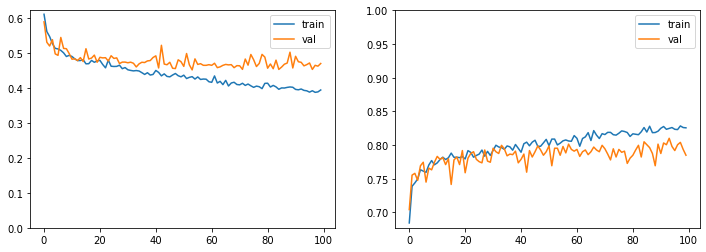

In [18]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6406 - accuracy: 0.5291 - precision: 0.9023 - recall: 0.4580 - f1: 0.5852 - specificity: 0.7760 - negative_predictive_value: 0.2603 - matthews_correlation_coefficient: 0.2018 - val_loss: 0.6189 - val_accuracy: 0.4866 - val_precision: 0.9020 - val_recall: 0.3665 - val_f1: 0.5162 - val_specificity: 0.8751 - val_negative_predictive_value: 0.2728 - val_matthews_correlation_coefficient: 0.2312

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23120, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_18-22_24_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6228 - accuracy: 0.5492 - precision: 0.9049 - recall: 0.4762 - f1: 0.6110 - specificity: 0.7969 - negative_predictive_value: 0.2909 - matthews_correlation_coefficient: 0.2347 - val_loss: 0.6466 - val_accuracy: 0.5568 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33307
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5729 - accuracy: 0.6458 - precision: 0.9191 - recall: 0.6090 - f1: 0.7226 - specificity: 0.7856 - negative_predictive_value: 0.3579 - matthews_correlation_coefficient: 0.3285 - val_loss: 0.5322 - val_accuracy: 0.7095 - val_precision: 0.8994 - val_recall: 0.7200 - val_f1: 0.7946 - val_specificity: 0.6800 - val_negative_predictive_value: 0.3960 - val_matthews_correlation_coefficient: 0.3426

Epoch 00015: val_matthews_correlation_coefficient improved from 0.33307 to 0.34259, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_18-22_24_13.h5
Epoch 16/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5696 - accuracy: 0.6536 - precision: 0.9169 - recall: 0.6189 - f1: 0.7288 - specificity: 0.7730 - negative_predictive_value: 0.3632 - matthews_correlation_coefficient: 0.3298 - val_loss: 0.6231 - va

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5397 - accuracy: 0.6998 - precision: 0.9218 - recall: 0.6788 - f1: 0.7747 - specificity: 0.7769 - negative_predictive_value: 0.3971 - matthews_correlation_coefficient: 0.3791 - val_loss: 0.5932 - val_accuracy: 0.6088 - val_precision: 0.9101 - val_recall: 0.5256 - val_f1: 0.6608 - val_specificity: 0.8417 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.3239

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36813
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5400 - accuracy: 0.6826 - precision: 0.9250 - recall: 0.6519 - f1: 0.7574 - specificity: 0.7872 - negative_predictive_value: 0.3846 - matthews_correlation_coefficient: 0.3677 - val_loss: 0.4738 - val_accuracy: 0.7710 - val_precision: 0.8975 - val_recall: 0.8097 - val_f1: 0.8478 - val_specificity: 0.6412 - val_negative_predictive_value: 0.4766 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.40837
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5274 - accuracy: 0.6998 - precision: 0.9251 - recall: 0.6795 - f1: 0.7753 - specificity: 0.7872 - negative_predictive_value: 0.4120 - matthews_correlation_coefficient: 0.3926 - val_loss: 0.6615 - val_accuracy: 0.5863 - val_precision: 0.9192 - val_recall: 0.4897 - val_f1: 0.6332 - val_specificity: 0.8733 - val_negative_predictive_value: 0.3238 - val_matthews_correlation_coefficient: 0.3231

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40837
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5182 - accuracy: 0.7054 - precision: 0.9306 - recall: 0.6820 - f1: 0.7812 - specificity: 0.7981 - negative_predictive_value: 0.4048 - matthews_correlation_coefficient: 0.3981 - val_loss: 0.4814 - val_accuracy: 0.7641 - val_precision: 0.8902 - val_recall: 0.8058 - val_f1: 0.8427 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40837
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5008 - accuracy: 0.7228 - precision: 0.9338 - recall: 0.6992 - f1: 0.7934 - specificity: 0.7946 - negative_predictive_value: 0.4242 - matthews_correlation_coefficient: 0.4186 - val_loss: 0.5062 - val_accuracy: 0.7042 - val_precision: 0.9227 - val_recall: 0.6873 - val_f1: 0.7836 - val_specificity: 0.7767 - val_negative_predictive_value: 0.3962 - val_matthews_correlation_coefficient: 0.3835

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40837
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5075 - accuracy: 0.7213 - precision: 0.9282 - recall: 0.7053 - f1: 0.7932 - specificity: 0.7738 - negative_predictive_value: 0.4185 - matthews_correlation_coefficient: 0.4049 - val_loss: 0.6036 - val_accuracy: 0.6496 - val_precision: 0.9268 - val_recall: 0.6112 - val_f1: 0.7304 - val_spe

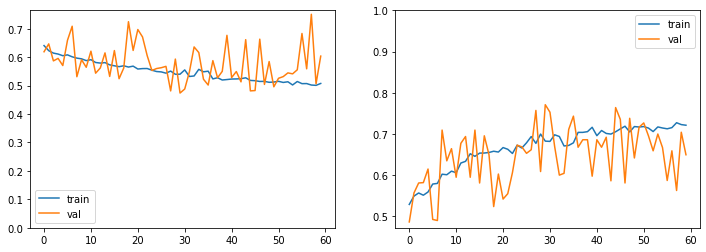

In [19]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4475 - accuracy: 0.7716 - precision: 0.8492 - recall: 0.7538 - f1: 0.7902 - specificity: 0.8001 - negative_predictive_value: 0.6832 - matthews_correlation_coefficient: 0.5417 - val_loss: 0.4755 - val_accuracy: 0.7554 - val_precision: 0.9488 - val_recall: 0.6407 - val_f1: 0.7570 - val_specificity: 0.9247 - val_negative_predictive_value: 0.6110 - val_matthews_correlation_coefficient: 0.5611

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.56109, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_18-22_33_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3932 - accuracy: 0.8030 - precision: 0.8957 - recall: 0.7557 - f1: 0.8141 - specificity: 0.8791 - negative_predictive_value: 0.7016 - matthews_correlation_coefficient: 0.6169 - val_loss: 0.4104 - val_accuracy: 0.8057 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.69163
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3185 - accuracy: 0.8592 - precision: 0.9240 - recall: 0.8404 - f1: 0.8772 - specificity: 0.8955 - negative_predictive_value: 0.7820 - matthews_correlation_coefficient: 0.7202 - val_loss: 0.3340 - val_accuracy: 0.8578 - val_precision: 0.8941 - val_recall: 0.8722 - val_f1: 0.8811 - val_specificity: 0.8232 - val_negative_predictive_value: 0.7839 - val_matthews_correlation_coefficient: 0.6863

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.69163
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3155 - accuracy: 0.8542 - precision: 0.9271 - recall: 0.8286 - f1: 0.8712 - specificity: 0.8919 - negative_predictive_value: 0.7681 - matthews_correlation_coefficient: 0.7073 - val_loss: 0.3203 - val_accuracy: 0.8612 - val_precision: 0.9233 - val_recall: 0.8462 - val_f1: 0.8807 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2981 - accuracy: 0.8733 - precision: 0.9295 - recall: 0.8618 - f1: 0.8905 - specificity: 0.8967 - negative_predictive_value: 0.7977 - matthews_correlation_coefficient: 0.7418 - val_loss: 0.3110 - val_accuracy: 0.8656 - val_precision: 0.9200 - val_recall: 0.8556 - val_f1: 0.8848 - val_specificity: 0.8653 - val_negative_predictive_value: 0.7738 - val_matthews_correlation_coefficient: 0.7069

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.73474
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2898 - accuracy: 0.8662 - precision: 0.9196 - recall: 0.8535 - f1: 0.8810 - specificity: 0.8806 - negative_predictive_value: 0.7949 - matthews_correlation_coefficient: 0.7253 - val_loss: 0.3166 - val_accuracy: 0.8578 - val_precision: 0.9120 - val_recall: 0.8521 - val_f1: 0.8788 - val_specificity: 0.8525 - val_negative_predictive_value: 0.7659 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.76033
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2698 - accuracy: 0.8846 - precision: 0.9303 - recall: 0.8775 - f1: 0.9004 - specificity: 0.8963 - negative_predictive_value: 0.8204 - matthews_correlation_coefficient: 0.7618 - val_loss: 0.2821 - val_accuracy: 0.8925 - val_precision: 0.9027 - val_recall: 0.9249 - val_f1: 0.9117 - val_specificity: 0.8240 - val_negative_predictive_value: 0.8563 - val_matthews_correlation_coefficient: 0.7537

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.76033
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2694 - accuracy: 0.8859 - precision: 0.9273 - recall: 0.8770 - f1: 0.8980 - specificity: 0.8943 - negative_predictive_value: 0.8241 - matthews_correlation_coefficient: 0.7624 - val_loss: 0.3025 - val_accuracy: 0.8638 - val_precision: 0.8509 - val_recall: 0.9448 - val_f1: 0.8933 - val_spe


Epoch 00058: val_matthews_correlation_coefficient improved from 0.76723 to 0.77535, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_18-22_33_24.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2437 - accuracy: 0.9002 - precision: 0.9353 - recall: 0.8972 - f1: 0.9134 - specificity: 0.8989 - negative_predictive_value: 0.8500 - matthews_correlation_coefficient: 0.7902 - val_loss: 0.2770 - val_accuracy: 0.9055 - val_precision: 0.9142 - val_recall: 0.9342 - val_f1: 0.9224 - val_specificity: 0.8436 - val_negative_predictive_value: 0.8687 - val_matthews_correlation_coefficient: 0.7800

Epoch 00059: val_matthews_correlation_coefficient improved from 0.77535 to 0.77999, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_18-22_33_24.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2567 - accuracy: 0.8924 - precision: 0.9265 - recall: 0.8976 - f1: 0.9087 - specificity:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2487 - accuracy: 0.8987 - precision: 0.9354 - recall: 0.8953 - f1: 0.9113 - specificity: 0.8991 - negative_predictive_value: 0.8454 - matthews_correlation_coefficient: 0.7887 - val_loss: 0.2716 - val_accuracy: 0.9081 - val_precision: 0.9088 - val_recall: 0.9457 - val_f1: 0.9256 - val_specificity: 0.8313 - val_negative_predictive_value: 0.8801 - val_matthews_correlation_coefficient: 0.7828

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.79652
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2491 - accuracy: 0.8926 - precision: 0.9243 - recall: 0.8972 - f1: 0.9070 - specificity: 0.8845 - negative_predictive_value: 0.8429 - matthews_correlation_coefficient: 0.7755 - val_loss: 0.2859 - val_accuracy: 0.8899 - val_precision: 0.9172 - val_recall: 0.9025 - val_f1: 0.9080 - val_specificity: 0.8519 - val_negative_predictive_value: 0.8277 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2273 - accuracy: 0.9106 - precision: 0.9344 - recall: 0.9069 - f1: 0.9185 - specificity: 0.9043 - negative_predictive_value: 0.8618 - matthews_correlation_coefficient: 0.8102 - val_loss: 0.2728 - val_accuracy: 0.9055 - val_precision: 0.9243 - val_recall: 0.9229 - val_f1: 0.9218 - val_specificity: 0.8654 - val_negative_predictive_value: 0.8529 - val_matthews_correlation_coefficient: 0.7824

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.79652
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2490 - accuracy: 0.8924 - precision: 0.9336 - recall: 0.8845 - f1: 0.9055 - specificity: 0.9097 - negative_predictive_value: 0.8412 - matthews_correlation_coefficient: 0.7841 - val_loss: 0.2549 - val_accuracy: 0.9063 - val_precision: 0.8987 - val_recall: 0.9549 - val_f1: 0.9245 - val_specificity: 0.8132 - val_negative_predictive_value: 0.8966 - val_matthews_correlation_coefficie

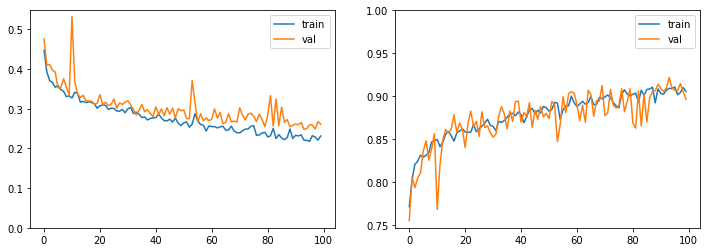

In [20]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6078 - accuracy: 0.6579 - precision: 0.7043 - recall: 0.6851 - f1: 0.6736 - specificity: 0.6302 - negative_predictive_value: 0.6368 - matthews_correlation_coefficient: 0.3258 - val_loss: 0.5571 - val_accuracy: 0.7016 - val_precision: 0.7472 - val_recall: 0.7233 - val_f1: 0.7303 - val_specificity: 0.6570 - val_negative_predictive_value: 0.6320 - val_matthews_correlation_coefficient: 0.3796

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37958, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_18-22_48_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5767 - accuracy: 0.6915 - precision: 0.7493 - recall: 0.7067 - f1: 0.7100 - specificity: 0.6784 - negative_predictive_value: 0.6550 - matthews_correlation_coefficient: 0.3955 - val_loss: 0.5555 - val_accuracy: 0.7294 - val_p


Epoch 00014: val_matthews_correlation_coefficient improved from 0.53219 to 0.55629, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_18-22_48_24.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5013 - accuracy: 0.7577 - precision: 0.7791 - recall: 0.8115 - f1: 0.7873 - specificity: 0.6977 - negative_predictive_value: 0.7464 - matthews_correlation_coefficient: 0.5168 - val_loss: 0.4855 - val_accuracy: 0.7936 - val_precision: 0.7726 - val_recall: 0.9128 - val_f1: 0.8331 - val_specificity: 0.6257 - val_negative_predictive_value: 0.8284 - val_matthews_correlation_coefficient: 0.5676

Epoch 00015: val_matthews_correlation_coefficient improved from 0.55629 to 0.56756, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_18-22_48_24.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4988 - accuracy: 0.7564 - precision: 0.7798 - recall: 0.7969 - f1: 0.7805 - specificity:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4728 - accuracy: 0.7837 - precision: 0.7871 - recall: 0.8342 - f1: 0.8040 - specificity: 0.7121 - negative_predictive_value: 0.7773 - matthews_correlation_coefficient: 0.5545 - val_loss: 0.4883 - val_accuracy: 0.7667 - val_precision: 0.7252 - val_recall: 0.9564 - val_f1: 0.8214 - val_specificity: 0.5107 - val_negative_predictive_value: 0.8909 - val_matthews_correlation_coefficient: 0.5344

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.58577
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4846 - accuracy: 0.7681 - precision: 0.7839 - recall: 0.8241 - f1: 0.7959 - specificity: 0.7078 - negative_predictive_value: 0.7581 - matthews_correlation_coefficient: 0.5361 - val_loss: 0.4642 - val_accuracy: 0.7953 - val_precision: 0.7727 - val_recall: 0.9160 - val_f1: 0.8344 - val_specificity: 0.6284 - val_negative_predictive_value: 0.8336 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4578 - accuracy: 0.7866 - precision: 0.7962 - recall: 0.8444 - f1: 0.8128 - specificity: 0.7221 - negative_predictive_value: 0.7826 - matthews_correlation_coefficient: 0.5719 - val_loss: 0.4907 - val_accuracy: 0.7728 - val_precision: 0.7986 - val_recall: 0.8124 - val_f1: 0.8009 - val_specificity: 0.7112 - val_negative_predictive_value: 0.7248 - val_matthews_correlation_coefficient: 0.5231

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.60044
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4563 - accuracy: 0.7883 - precision: 0.8001 - recall: 0.8436 - f1: 0.8141 - specificity: 0.7162 - negative_predictive_value: 0.7802 - matthews_correlation_coefficient: 0.5709 - val_loss: 0.4403 - val_accuracy: 0.8092 - val_precision: 0.8131 - val_recall: 0.8746 - val_f1: 0.8386 - val_specificity: 0.7146 - val_negative_predictive_value: 0.7907 - val_matthews_correlation_coefficie


Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.60823
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4432 - accuracy: 0.7905 - precision: 0.8041 - recall: 0.8397 - f1: 0.8152 - specificity: 0.7270 - negative_predictive_value: 0.7770 - matthews_correlation_coefficient: 0.5730 - val_loss: 0.4486 - val_accuracy: 0.7953 - val_precision: 0.7995 - val_recall: 0.8631 - val_f1: 0.8272 - val_specificity: 0.6937 - val_negative_predictive_value: 0.7718 - val_matthews_correlation_coefficient: 0.5634

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.60823
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4421 - accuracy: 0.7970 - precision: 0.8092 - recall: 0.8431 - f1: 0.8203 - specificity: 0.7466 - negative_predictive_value: 0.7875 - matthews_correlation_coefficient: 0.5926 - val_loss: 0.4481 - val_accuracy: 0.8040 - val_precision: 0.7880 - val_recall: 0.9049 - val_f1: 0.8387 - val_spe


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.60823
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4375 - accuracy: 0.7941 - precision: 0.8095 - recall: 0.8401 - f1: 0.8191 - specificity: 0.7364 - negative_predictive_value: 0.7741 - matthews_correlation_coefficient: 0.5796 - val_loss: 0.4881 - val_accuracy: 0.7858 - val_precision: 0.8147 - val_recall: 0.8171 - val_f1: 0.8118 - val_specificity: 0.7368 - val_negative_predictive_value: 0.7342 - val_matthews_correlation_coefficient: 0.5509

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.60823
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4280 - accuracy: 0.8050 - precision: 0.8129 - recall: 0.8417 - f1: 0.8207 - specificity: 0.7526 - negative_predictive_value: 0.8014 - matthews_correlation_coefficient: 0.6052 - val_loss: 0.4368 - val_accuracy: 0.8144 - val_precision: 0.8256 - val_recall: 0.8634 - val_f1: 0.8406 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.63981
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4255 - accuracy: 0.8011 - precision: 0.8123 - recall: 0.8481 - f1: 0.8247 - specificity: 0.7481 - negative_predictive_value: 0.7970 - matthews_correlation_coefficient: 0.6020 - val_loss: 0.4229 - val_accuracy: 0.8265 - val_precision: 0.8215 - val_recall: 0.8958 - val_f1: 0.8537 - val_specificity: 0.7239 - val_negative_predictive_value: 0.8199 - val_matthews_correlation_coefficient: 0.6299

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.63981
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4300 - accuracy: 0.8009 - precision: 0.8123 - recall: 0.8461 - f1: 0.8225 - specificity: 0.7407 - negative_predictive_value: 0.7858 - matthews_correlation_coefficient: 0.5935 - val_loss: 0.4280 - val_accuracy: 0.8057 - val_precision: 0.7917 - val_recall: 0.9005 - val_f1: 0.8394 - val_spe

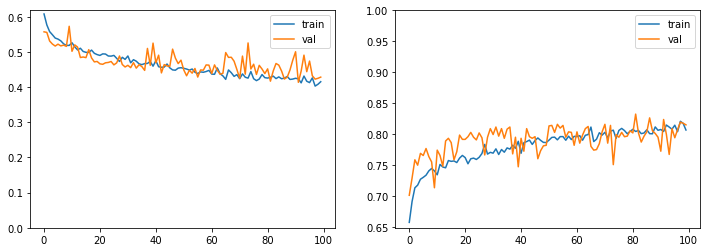

In [21]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5850 - accuracy: 0.5557 - precision: 0.9623 - recall: 0.5259 - f1: 0.6731 - specificity: 0.8160 - negative_predictive_value: 0.1851 - matthews_correlation_coefficient: 0.2225 - val_loss: 0.7290 - val_accuracy: 0.4571 - val_precision: 0.9543 - val_recall: 0.3844 - val_f1: 0.5428 - val_specificity: 0.9215 - val_negative_predictive_value: 0.1840 - val_matthews_correlation_coefficient: 0.2039

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20385, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_18-23_03_27.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5668 - accuracy: 0.5659 - precision: 0.9614 - recall: 0.5349 - f1: 0.6765 - specificity: 0.7767 - negative_predictive_value: 0.1823 - matthews_correlation_coefficient: 0.2088 - val_loss: 0.5952 - val_accuracy: 0.4848 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.29751
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4695 - accuracy: 0.7148 - precision: 0.9732 - recall: 0.7000 - f1: 0.8051 - specificity: 0.8044 - negative_predictive_value: 0.2809 - matthews_correlation_coefficient: 0.3493 - val_loss: 0.6296 - val_accuracy: 0.5941 - val_precision: 0.9599 - val_recall: 0.5375 - val_f1: 0.6845 - val_specificity: 0.9116 - val_negative_predictive_value: 0.2281 - val_matthews_correlation_coefficient: 0.2863

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.29751
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4711 - accuracy: 0.7106 - precision: 0.9680 - recall: 0.6986 - f1: 0.8013 - specificity: 0.7921 - negative_predictive_value: 0.2842 - matthews_correlation_coefficient: 0.3422 - val_loss: 0.4574 - val_accuracy: 0.7225 - val_precision: 0.9358 - val_recall: 0.6973 - val_f1: 0.7962 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4134 - accuracy: 0.7649 - precision: 0.9766 - recall: 0.7558 - f1: 0.8463 - specificity: 0.8271 - negative_predictive_value: 0.3239 - matthews_correlation_coefficient: 0.4097 - val_loss: 0.3584 - val_accuracy: 0.7823 - val_precision: 0.9257 - val_recall: 0.7735 - val_f1: 0.8411 - val_specificity: 0.6492 - val_negative_predictive_value: 0.2770 - val_matthews_correlation_coefficient: 0.3136

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36758
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3984 - accuracy: 0.7744 - precision: 0.9746 - recall: 0.7657 - f1: 0.8521 - specificity: 0.8412 - negative_predictive_value: 0.3270 - matthews_correlation_coefficient: 0.4230 - val_loss: 0.6724 - val_accuracy: 0.6088 - val_precision: 0.9686 - val_recall: 0.5474 - val_f1: 0.6951 - val_specificity: 0.9517 - val_negative_predictive_value: 0.2389 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3868 - accuracy: 0.7811 - precision: 0.9790 - recall: 0.7692 - f1: 0.8559 - specificity: 0.8427 - negative_predictive_value: 0.3368 - matthews_correlation_coefficient: 0.4300 - val_loss: 0.5828 - val_accuracy: 0.6496 - val_precision: 0.9436 - val_recall: 0.6094 - val_f1: 0.7368 - val_specificity: 0.8185 - val_negative_predictive_value: 0.2162 - val_matthews_correlation_coefficient: 0.2851

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36758
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3967 - accuracy: 0.7698 - precision: 0.9790 - recall: 0.7602 - f1: 0.8493 - specificity: 0.8495 - negative_predictive_value: 0.3377 - matthews_correlation_coefficient: 0.4293 - val_loss: 0.7921 - val_accuracy: 0.5681 - val_precision: 0.9651 - val_recall: 0.5050 - val_f1: 0.6579 - val_specificity: 0.9315 - val_negative_predictive_value: 0.2219 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39663
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3646 - accuracy: 0.7907 - precision: 0.9808 - recall: 0.7776 - f1: 0.8622 - specificity: 0.8645 - negative_predictive_value: 0.3522 - matthews_correlation_coefficient: 0.4543 - val_loss: 0.4967 - val_accuracy: 0.7095 - val_precision: 0.9622 - val_recall: 0.6621 - val_f1: 0.7808 - val_specificity: 0.9190 - val_negative_predictive_value: 0.2890 - val_matthews_correlation_coefficient: 0.3740

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39663
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3711 - accuracy: 0.7913 - precision: 0.9773 - recall: 0.7846 - f1: 0.8649 - specificity: 0.8670 - negative_predictive_value: 0.3547 - matthews_correlation_coefficient: 0.4563 - val_loss: 0.7582 - val_accuracy: 0.5872 - val_precision: 0.9650 - val_recall: 0.5269 - val_f1: 0.6757 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39663
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3385 - accuracy: 0.8106 - precision: 0.9811 - recall: 0.8013 - f1: 0.8791 - specificity: 0.8316 - negative_predictive_value: 0.3594 - matthews_correlation_coefficient: 0.4578 - val_loss: 0.6900 - val_accuracy: 0.6314 - val_precision: 0.9655 - val_recall: 0.5740 - val_f1: 0.7163 - val_specificity: 0.9337 - val_negative_predictive_value: 0.2455 - val_matthews_correlation_coefficient: 0.3208

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.39663
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3537 - accuracy: 0.8011 - precision: 0.9795 - recall: 0.7927 - f1: 0.8705 - specificity: 0.8794 - negative_predictive_value: 0.3655 - matthews_correlation_coefficient: 0.4737 - val_loss: 0.4788 - val_accuracy: 0.7459 - val_precision: 0.9549 - val_recall: 0.7091 - val_f1: 0.8116 - val_spe

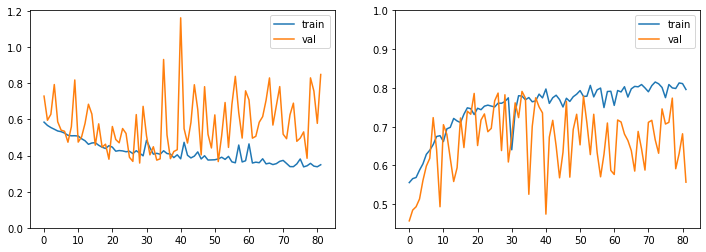

In [22]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5859 - accuracy: 0.6616 - precision: 0.9043 - recall: 0.6428 - f1: 0.7427 - specificity: 0.7392 - negative_predictive_value: 0.3638 - matthews_correlation_coefficient: 0.3181 - val_loss: 0.6666 - val_accuracy: 0.5898 - val_precision: 0.9200 - val_recall: 0.5393 - val_f1: 0.6738 - val_specificity: 0.7932 - val_negative_predictive_value: 0.3102 - val_matthews_correlation_coefficient: 0.2754

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27536, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_18-23_15_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5710 - accuracy: 0.6894 - precision: 0.8991 - recall: 0.6836 - f1: 0.7703 - specificity: 0.7060 - negative_predictive_value: 0.3870 - matthews_correlation_coefficient: 0.3331 - val_loss: 0.6118 - val_accuracy: 0.6366 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33679
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5298 - accuracy: 0.6816 - precision: 0.9243 - recall: 0.6506 - f1: 0.7566 - specificity: 0.8087 - negative_predictive_value: 0.3896 - matthews_correlation_coefficient: 0.3771 - val_loss: 0.6027 - val_accuracy: 0.6288 - val_precision: 0.9314 - val_recall: 0.5811 - val_f1: 0.7111 - val_specificity: 0.8227 - val_negative_predictive_value: 0.3401 - val_matthews_correlation_coefficient: 0.3297

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.33679
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5279 - accuracy: 0.6907 - precision: 0.9190 - recall: 0.6691 - f1: 0.7677 - specificity: 0.7769 - negative_predictive_value: 0.3911 - matthews_correlation_coefficient: 0.3694 - val_loss: 0.5923 - val_accuracy: 0.6730 - val_precision: 0.9100 - val_recall: 0.6597 - val_f1: 0.7608 - val_spe


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.36938
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5177 - accuracy: 0.7087 - precision: 0.9260 - recall: 0.6893 - f1: 0.7816 - specificity: 0.7819 - negative_predictive_value: 0.4156 - matthews_correlation_coefficient: 0.4002 - val_loss: 0.5283 - val_accuracy: 0.6973 - val_precision: 0.9280 - val_recall: 0.6790 - val_f1: 0.7807 - val_specificity: 0.7760 - val_negative_predictive_value: 0.3873 - val_matthews_correlation_coefficient: 0.3772

Epoch 00029: val_matthews_correlation_coefficient improved from 0.36938 to 0.37720, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_18-23_15_48.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4999 - accuracy: 0.7217 - precision: 0.9185 - recall: 0.7004 - f1: 0.7898 - specificity: 0.7827 - negative_predictive_value: 0.4195 - matthews_correlation_coefficient: 0.4074 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4859 - accuracy: 0.7334 - precision: 0.9272 - recall: 0.7214 - f1: 0.8043 - specificity: 0.7828 - negative_predictive_value: 0.4466 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.5803 - val_accuracy: 0.6652 - val_precision: 0.9405 - val_recall: 0.6241 - val_f1: 0.7462 - val_specificity: 0.8299 - val_negative_predictive_value: 0.3666 - val_matthews_correlation_coefficient: 0.3719

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39305
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4780 - accuracy: 0.7380 - precision: 0.9326 - recall: 0.7255 - f1: 0.8096 - specificity: 0.8002 - negative_predictive_value: 0.4498 - matthews_correlation_coefficient: 0.4440 - val_loss: 0.6290 - val_accuracy: 0.6305 - val_precision: 0.9574 - val_recall: 0.5661 - val_f1: 0.7062 - val_specificity: 0.8846 - val_negative_predictive_value: 0.3483 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.40143
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4665 - accuracy: 0.7416 - precision: 0.9321 - recall: 0.7266 - f1: 0.8096 - specificity: 0.7893 - negative_predictive_value: 0.4507 - matthews_correlation_coefficient: 0.4427 - val_loss: 0.6150 - val_accuracy: 0.6704 - val_precision: 0.9505 - val_recall: 0.6231 - val_f1: 0.7490 - val_specificity: 0.8525 - val_negative_predictive_value: 0.3719 - val_matthews_correlation_coefficient: 0.3900

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40143
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4575 - accuracy: 0.7527 - precision: 0.9331 - recall: 0.7436 - f1: 0.8211 - specificity: 0.7949 - negative_predictive_value: 0.4713 - matthews_correlation_coefficient: 0.4618 - val_loss: 0.5928 - val_accuracy: 0.6522 - val_precision: 0.9482 - val_recall: 0.6005 - val_f1: 0.7313 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4561 - accuracy: 0.7581 - precision: 0.9303 - recall: 0.7503 - f1: 0.8236 - specificity: 0.7699 - negative_predictive_value: 0.4668 - matthews_correlation_coefficient: 0.4516 - val_loss: 0.5433 - val_accuracy: 0.6869 - val_precision: 0.9363 - val_recall: 0.6568 - val_f1: 0.7678 - val_specificity: 0.8078 - val_negative_predictive_value: 0.3821 - val_matthews_correlation_coefficient: 0.3830

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.43183
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4505 - accuracy: 0.7612 - precision: 0.9327 - recall: 0.7543 - f1: 0.8299 - specificity: 0.7939 - negative_predictive_value: 0.4653 - matthews_correlation_coefficient: 0.4637 - val_loss: 0.5490 - val_accuracy: 0.6878 - val_precision: 0.9371 - val_recall: 0.6561 - val_f1: 0.7688 - val_specificity: 0.8120 - val_negative_predictive_value: 0.3812 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4354 - accuracy: 0.7685 - precision: 0.9325 - recall: 0.7631 - f1: 0.8344 - specificity: 0.7870 - negative_predictive_value: 0.4837 - matthews_correlation_coefficient: 0.4756 - val_loss: 0.5901 - val_accuracy: 0.6739 - val_precision: 0.9477 - val_recall: 0.6303 - val_f1: 0.7526 - val_specificity: 0.8410 - val_negative_predictive_value: 0.3738 - val_matthews_correlation_coefficient: 0.3878

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.43183
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4343 - accuracy: 0.7774 - precision: 0.9391 - recall: 0.7673 - f1: 0.8395 - specificity: 0.8108 - negative_predictive_value: 0.4942 - matthews_correlation_coefficient: 0.4975 - val_loss: 0.6202 - val_accuracy: 0.6392 - val_precision: 0.9392 - val_recall: 0.5896 - val_f1: 0.7196 - val_specificity: 0.8374 - val_negative_predictive_value: 0.3487 - val_matthews_correlation_coefficie

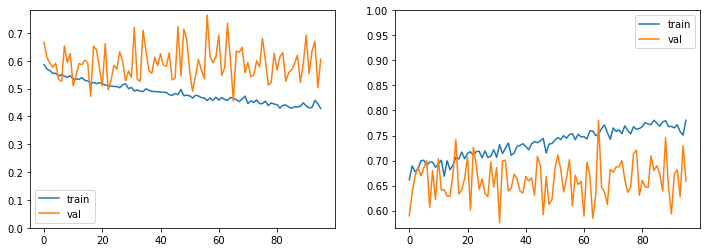

In [23]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_18-23_30_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1736 - accuracy: 0.8946 - precision: 1.0000 - recall: 0.8950 - f1: 0.9432 - specificity: 0.0966 - negative_predictive_value: 0.0311 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.1824 - val_accuracy: 0.9237 - val_precision: 1.0000 - val_recall: 0.9255 - val_f1: 0.9606 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficient: 0.0655

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1314 - accuracy: 0.9234 - precision: 1.0000 - recall: 0.9237 - f1: 0.9596 - specificity: 0.0966 - negative_predictive_value: 0.0402 - matthews_correlation_coefficient: 0.0575 - val_loss: 0.0629 - val_accuracy: 0.9679 - val_precision: 1.0000 - val_recall: 0.9687 - val_f1: 0.9837 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_18-23_30_10.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1748 - accuracy: 0.9100 - precision: 1.0000 - recall: 0.9103 - f1: 0.9508 - specificity: 0.1034 - negative_predictive_value: 0.0577 - matthews_correlation_coefficient: 0.0703 - val_loss: 0.2664 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9186 - val_f1: 0.9567 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficient: 0.0651

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1281 - accuracy: 0.9328 - precision: 1.0000 - recall: 0.9330 - f1: 0.9647 - specificity: 0.0966 - negative_predictive_value: 0.0426 - matthews_correlation_coefficient: 0.0599 - val_loss: 0.13


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0976 - accuracy: 0.9538 - precision: 1.0000 - recall: 0.9540 - f1: 0.9760 - specificity: 0.1034 - negative_predictive_value: 0.0583 - matthews_correlation_coefficient: 0.0741 - val_loss: 0.1736 - val_accuracy: 0.9341 - val_precision: 1.0000 - val_recall: 0.9357 - val_f1: 0.9661 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0495 - val_matthews_correlation_coefficient: 0.0715

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0669 - accuracy: 0.9588 - precision: 1.0000 - recall: 0.9590 - f1: 0.9786 - specificity: 0.1034 - negative_predictive_value: 0.0713 - matthews_correlation_coefficient: 0.0827 - val_loss: 0.0510 - val_accuracy: 0.9792 - val_precision: 1.0000 - val_recall: 0.9797 - val_f1: 0.9895 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.18%
  Final Precision: 100.00%
     Final Recall:  98.17%
  Final F-measure:  99.08%
Final Specificity: 100.00%
        Final NPV:  16.00%
        Final MCC:  39.63%
[[   4    0]
 [  21 1128]]
              precision    recall  f1-score   support

           0       0.16      1.00      0.28         4
           1       1.00      0.98      0.99      1149

    accuracy                           0.98      1153
   macro avg       0.58      0.99      0.63      1153
weighted avg       1.00      0.98      0.99      1153



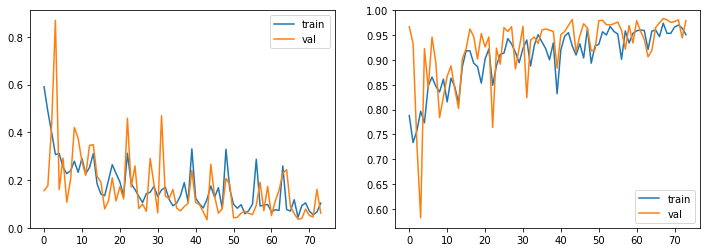

In [24]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6013 - accuracy: 0.6200 - precision: 0.8760 - recall: 0.5514 - f1: 0.6618 - specificity: 0.7928 - negative_predictive_value: 0.4154 - matthews_correlation_coefficient: 0.3214 - val_loss: 0.5856 - val_accuracy: 0.6357 - val_precision: 0.8467 - val_recall: 0.5506 - val_f1: 0.6632 - val_specificity: 0.7836 - val_negative_predictive_value: 0.4280 - val_matthews_correlation_coefficient: 0.3285

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32851, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_18-23_41_17.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5909 - accuracy: 0.6328 - precision: 0.8867 - recall: 0.5569 - f1: 0.6745 - specificity: 0.8163 - negative_predictive_value: 0.4367 - matthews_correlation_coefficient: 0.3473 - val_loss: 0.6619 - val_accuracy: 0.5568 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5499 - accuracy: 0.6967 - precision: 0.9012 - recall: 0.6434 - f1: 0.7432 - specificity: 0.8310 - negative_predictive_value: 0.4965 - matthews_correlation_coefficient: 0.4335 - val_loss: 0.6188 - val_accuracy: 0.6513 - val_precision: 0.9012 - val_recall: 0.5349 - val_f1: 0.6665 - val_specificity: 0.8696 - val_negative_predictive_value: 0.4436 - val_matthews_correlation_coefficient: 0.3982

Epoch 00015: val_matthews_correlation_coefficient improved from 0.36904 to 0.39825, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_18-23_41_17.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5444 - accuracy: 0.6883 - precision: 0.9017 - recall: 0.6316 - f1: 0.7358 - specificity: 0.8200 - negative_predictive_value: 0.4818 - matthews_correlation_coefficient: 0.4144 - val_loss: 0.5583 - val_accuracy: 0.6739 - val_precision: 0.8605 - val_recall: 0.6025 - val_f1: 0.7030 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5106 - accuracy: 0.7228 - precision: 0.9095 - recall: 0.6768 - f1: 0.7710 - specificity: 0.8370 - negative_predictive_value: 0.5201 - matthews_correlation_coefficient: 0.4682 - val_loss: 0.5202 - val_accuracy: 0.7069 - val_precision: 0.8106 - val_recall: 0.7088 - val_f1: 0.7531 - val_specificity: 0.6462 - val_negative_predictive_value: 0.4916 - val_matthews_correlation_coefficient: 0.3533

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40999
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5142 - accuracy: 0.7213 - precision: 0.9133 - recall: 0.6696 - f1: 0.7656 - specificity: 0.8467 - negative_predictive_value: 0.5228 - matthews_correlation_coefficient: 0.4746 - val_loss: 0.5320 - val_accuracy: 0.7086 - val_precision: 0.8496 - val_recall: 0.6681 - val_f1: 0.7434 - val_specificity: 0.7526 - val_negative_predictive_value: 0.4975 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5278 - accuracy: 0.7121 - precision: 0.9065 - recall: 0.6624 - f1: 0.7559 - specificity: 0.8219 - negative_predictive_value: 0.5157 - matthews_correlation_coefficient: 0.4519 - val_loss: 0.5167 - val_accuracy: 0.7207 - val_precision: 0.8508 - val_recall: 0.6837 - val_f1: 0.7546 - val_specificity: 0.7520 - val_negative_predictive_value: 0.5087 - val_matthews_correlation_coefficient: 0.4213

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43115
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4961 - accuracy: 0.7360 - precision: 0.9090 - recall: 0.6992 - f1: 0.7842 - specificity: 0.8286 - negative_predictive_value: 0.5385 - matthews_correlation_coefficient: 0.4846 - val_loss: 0.5160 - val_accuracy: 0.7190 - val_precision: 0.7957 - val_recall: 0.7494 - val_f1: 0.7692 - val_specificity: 0.5917 - val_negative_predictive_value: 0.5077 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4785 - accuracy: 0.7364 - precision: 0.9060 - recall: 0.6901 - f1: 0.7779 - specificity: 0.8371 - negative_predictive_value: 0.5373 - matthews_correlation_coefficient: 0.4816 - val_loss: 0.5308 - val_accuracy: 0.7077 - val_precision: 0.8153 - val_recall: 0.7030 - val_f1: 0.7523 - val_specificity: 0.6589 - val_negative_predictive_value: 0.4916 - val_matthews_correlation_coefficient: 0.3591

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43115
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4880 - accuracy: 0.7364 - precision: 0.9096 - recall: 0.6955 - f1: 0.7826 - specificity: 0.8280 - negative_predictive_value: 0.5389 - matthews_correlation_coefficient: 0.4847 - val_loss: 0.5688 - val_accuracy: 0.6869 - val_precision: 0.8919 - val_recall: 0.5955 - val_f1: 0.7092 - val_specificity: 0.8436 - val_negative_predictive_value: 0.4723 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.43995
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4721 - accuracy: 0.7438 - precision: 0.9134 - recall: 0.7079 - f1: 0.7911 - specificity: 0.8401 - negative_predictive_value: 0.5537 - matthews_correlation_coefficient: 0.5042 - val_loss: 0.6326 - val_accuracy: 0.6609 - val_precision: 0.8694 - val_recall: 0.5748 - val_f1: 0.6871 - val_specificity: 0.8115 - val_negative_predictive_value: 0.4504 - val_matthews_correlation_coefficient: 0.3768

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.43995
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4719 - accuracy: 0.7423 - precision: 0.9106 - recall: 0.7044 - f1: 0.7894 - specificity: 0.8406 - negative_predictive_value: 0.5488 - matthews_correlation_coefficient: 0.4984 - val_loss: 0.5036 - val_accuracy: 0.7216 - val_precision: 0.8347 - val_recall: 0.7044 - val_f1: 0.7604 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.44138
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4605 - accuracy: 0.7644 - precision: 0.9112 - recall: 0.7262 - f1: 0.8038 - specificity: 0.8480 - negative_predictive_value: 0.5755 - matthews_correlation_coefficient: 0.5264 - val_loss: 0.6787 - val_accuracy: 0.6496 - val_precision: 0.9019 - val_recall: 0.5347 - val_f1: 0.6644 - val_specificity: 0.8665 - val_negative_predictive_value: 0.4452 - val_matthews_correlation_coefficient: 0.3980

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.44138
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4784 - accuracy: 0.7430 - precision: 0.9157 - recall: 0.6985 - f1: 0.7848 - specificity: 0.8319 - negative_predictive_value: 0.5429 - matthews_correlation_coefficient: 0.4936 - val_loss: 0.5219 - val_accuracy: 0.7190 - val_precision: 0.8351 - val_recall: 0.6999 - val_f1: 0.7580 - val_spe

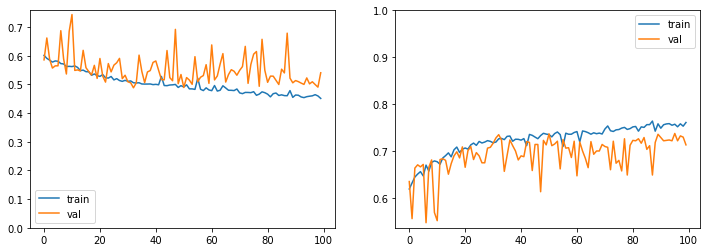

In [25]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5981 - accuracy: 0.5933 - precision: 0.9314 - recall: 0.5713 - f1: 0.6960 - specificity: 0.7422 - negative_predictive_value: 0.2314 - matthews_correlation_coefficient: 0.2216 - val_loss: 0.5412 - val_accuracy: 0.6357 - val_precision: 0.9053 - val_recall: 0.6024 - val_f1: 0.7202 - val_specificity: 0.7361 - val_negative_predictive_value: 0.2473 - val_matthews_correlation_coefficient: 0.2501

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25012, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_18-23_56_17.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.6158 - precision: 0.9447 - recall: 0.5901 - f1: 0.7159 - specificity: 0.7877 - negative_predictive_value: 0.2516 - matthews_correlation_coefficient: 0.2675 - val_loss: 0.4843 - val_accuracy: 0.7034 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38685
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4940 - accuracy: 0.6911 - precision: 0.9543 - recall: 0.6758 - f1: 0.7826 - specificity: 0.7834 - negative_predictive_value: 0.3030 - matthews_correlation_coefficient: 0.3399 - val_loss: 0.4382 - val_accuracy: 0.7598 - val_precision: 0.9517 - val_recall: 0.7651 - val_f1: 0.8451 - val_specificity: 0.7825 - val_negative_predictive_value: 0.3448 - val_matthews_correlation_coefficient: 0.3947

Epoch 00015: val_matthews_correlation_coefficient improved from 0.38685 to 0.39474, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_18-23_56_17.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4887 - accuracy: 0.7115 - precision: 0.9518 - recall: 0.6978 - f1: 0.7990 - specificity: 0.7933 - negative_predictive_value: 0.3173 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5167 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4525 - accuracy: 0.7310 - precision: 0.9545 - recall: 0.7103 - f1: 0.8104 - specificity: 0.8094 - negative_predictive_value: 0.3338 - matthews_correlation_coefficient: 0.3899 - val_loss: 0.5685 - val_accuracy: 0.6531 - val_precision: 0.9796 - val_recall: 0.6144 - val_f1: 0.7499 - val_specificity: 0.9180 - val_negative_predictive_value: 0.2823 - val_matthews_correlation_coefficient: 0.3665

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42859
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5206 - accuracy: 0.6794 - precision: 0.9574 - recall: 0.6621 - f1: 0.7659 - specificity: 0.8062 - negative_predictive_value: 0.3140 - matthews_correlation_coefficient: 0.3496 - val_loss: 0.4784 - val_accuracy: 0.7233 - val_precision: 0.9627 - val_recall: 0.7112 - val_f1: 0.8137 - val_specificity: 0.8387 - val_negative_predictive_value: 0.3219 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4229 - accuracy: 0.7549 - precision: 0.9635 - recall: 0.7439 - f1: 0.8348 - specificity: 0.8120 - negative_predictive_value: 0.3594 - matthews_correlation_coefficient: 0.4194 - val_loss: 0.4114 - val_accuracy: 0.7632 - val_precision: 0.9628 - val_recall: 0.7589 - val_f1: 0.8455 - val_specificity: 0.8076 - val_negative_predictive_value: 0.3562 - val_matthews_correlation_coefficient: 0.4185

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42859
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4409 - accuracy: 0.7371 - precision: 0.9639 - recall: 0.7220 - f1: 0.8183 - specificity: 0.8231 - negative_predictive_value: 0.3507 - matthews_correlation_coefficient: 0.4076 - val_loss: 0.3720 - val_accuracy: 0.8170 - val_precision: 0.9377 - val_recall: 0.8483 - val_f1: 0.8889 - val_specificity: 0.6336 - val_negative_predictive_value: 0.3960 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44494
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4043 - accuracy: 0.7703 - precision: 0.9690 - recall: 0.7583 - f1: 0.8470 - specificity: 0.8375 - negative_predictive_value: 0.3721 - matthews_correlation_coefficient: 0.4422 - val_loss: 0.3762 - val_accuracy: 0.7971 - val_precision: 0.9539 - val_recall: 0.8072 - val_f1: 0.8720 - val_specificity: 0.7717 - val_negative_predictive_value: 0.3900 - val_matthews_correlation_coefficient: 0.4372

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.44494
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4170 - accuracy: 0.7492 - precision: 0.9677 - recall: 0.7359 - f1: 0.8311 - specificity: 0.8327 - negative_predictive_value: 0.3599 - matthews_correlation_coefficient: 0.4259 - val_loss: 0.3231 - val_accuracy: 0.8387 - val_precision: 0.9399 - val_recall: 0.8717 - val_f1: 0.9028 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3952 - accuracy: 0.7738 - precision: 0.9633 - recall: 0.7663 - f1: 0.8496 - specificity: 0.8241 - negative_predictive_value: 0.3775 - matthews_correlation_coefficient: 0.4400 - val_loss: 0.3849 - val_accuracy: 0.7936 - val_precision: 0.9545 - val_recall: 0.8041 - val_f1: 0.8701 - val_specificity: 0.7596 - val_negative_predictive_value: 0.3878 - val_matthews_correlation_coefficient: 0.4300

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46471
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3961 - accuracy: 0.7642 - precision: 0.9625 - recall: 0.7542 - f1: 0.8397 - specificity: 0.8438 - negative_predictive_value: 0.3773 - matthews_correlation_coefficient: 0.4433 - val_loss: 0.3355 - val_accuracy: 0.8283 - val_precision: 0.9250 - val_recall: 0.8763 - val_f1: 0.8982 - val_specificity: 0.5711 - val_negative_predictive_value: 0.4103 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3829 - accuracy: 0.7868 - precision: 0.9607 - recall: 0.7826 - f1: 0.8579 - specificity: 0.8143 - negative_predictive_value: 0.3949 - matthews_correlation_coefficient: 0.4574 - val_loss: 0.3738 - val_accuracy: 0.8118 - val_precision: 0.9501 - val_recall: 0.8297 - val_f1: 0.8838 - val_specificity: 0.7390 - val_negative_predictive_value: 0.4070 - val_matthews_correlation_coefficient: 0.4411

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46760
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4068 - accuracy: 0.7625 - precision: 0.9674 - recall: 0.7502 - f1: 0.8381 - specificity: 0.8480 - negative_predictive_value: 0.3808 - matthews_correlation_coefficient: 0.4497 - val_loss: 0.2837 - val_accuracy: 0.8768 - val_precision: 0.9086 - val_recall: 0.9565 - val_f1: 0.9307 - val_specificity: 0.4452 - val_negative_predictive_value: 0.5699 - val_matthews_correlation_coefficie

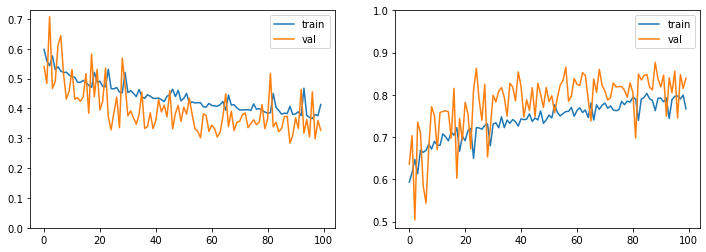

In [26]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4104 - accuracy: 0.7818 - precision: 0.9920 - recall: 0.7717 - f1: 0.8636 - specificity: 0.8034 - negative_predictive_value: 0.2259 - matthews_correlation_coefficient: 0.3536 - val_loss: 0.4414 - val_accuracy: 0.7988 - val_precision: 0.9648 - val_recall: 0.7712 - val_f1: 0.8559 - val_specificity: 0.7883 - val_negative_predictive_value: 0.2139 - val_matthews_correlation_coefficient: 0.3426

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34265, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_19-00_11_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3216 - accuracy: 0.8655 - precision: 0.9920 - recall: 0.8621 - f1: 0.9199 - specificity: 0.7196 - negative_predictive_value: 0.3095 - matthews_correlation_coefficient: 0.4162 - val_loss: 0.4480 - val_accuracy: 0.8153 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2446 - accuracy: 0.9145 - precision: 0.9920 - recall: 0.9167 - f1: 0.9518 - specificity: 0.7906 - negative_predictive_value: 0.4231 - matthews_correlation_coefficient: 0.5326 - val_loss: 0.2253 - val_accuracy: 0.9202 - val_precision: 0.9652 - val_recall: 0.8981 - val_f1: 0.9298 - val_specificity: 0.7748 - val_negative_predictive_value: 0.4051 - val_matthews_correlation_coefficient: 0.5157

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55556
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2447 - accuracy: 0.9113 - precision: 0.9921 - recall: 0.9133 - f1: 0.9500 - specificity: 0.7911 - negative_predictive_value: 0.4105 - matthews_correlation_coefficient: 0.5225 - val_loss: 0.2100 - val_accuracy: 0.9245 - val_precision: 0.9652 - val_recall: 0.9026 - val_f1: 0.9324 - val_specificity: 0.7748 - val_negative_predictive_value: 0.4135 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2008 - accuracy: 0.9278 - precision: 0.9932 - recall: 0.9300 - f1: 0.9594 - specificity: 0.7705 - negative_predictive_value: 0.4763 - matthews_correlation_coefficient: 0.5638 - val_loss: 0.3098 - val_accuracy: 0.8977 - val_precision: 0.9671 - val_recall: 0.8730 - val_f1: 0.9170 - val_specificity: 0.7905 - val_negative_predictive_value: 0.3420 - val_matthews_correlation_coefficient: 0.4725

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.59476
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2185 - accuracy: 0.9245 - precision: 0.9934 - recall: 0.9267 - f1: 0.9578 - specificity: 0.7556 - negative_predictive_value: 0.4833 - matthews_correlation_coefficient: 0.5587 - val_loss: 0.1528 - val_accuracy: 0.9506 - val_precision: 0.9645 - val_recall: 0.9305 - val_f1: 0.9468 - val_specificity: 0.7613 - val_negative_predictive_value: 0.5266 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.63532
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1930 - accuracy: 0.9393 - precision: 0.9942 - recall: 0.9413 - f1: 0.9663 - specificity: 0.7900 - negative_predictive_value: 0.5154 - matthews_correlation_coefficient: 0.5998 - val_loss: 0.2626 - val_accuracy: 0.9089 - val_precision: 0.9663 - val_recall: 0.8859 - val_f1: 0.9236 - val_specificity: 0.7815 - val_negative_predictive_value: 0.3721 - val_matthews_correlation_coefficient: 0.4925

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.63532
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1831 - accuracy: 0.9416 - precision: 0.9937 - recall: 0.9446 - f1: 0.9678 - specificity: 0.7877 - negative_predictive_value: 0.5331 - matthews_correlation_coefficient: 0.6111 - val_loss: 0.2065 - val_accuracy: 0.9324 - val_precision: 0.9691 - val_recall: 0.9068 - val_f1: 0.9364 - val_spe


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.71649
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1520 - accuracy: 0.9479 - precision: 0.9945 - recall: 0.9471 - f1: 0.9689 - specificity: 0.7911 - negative_predictive_value: 0.5765 - matthews_correlation_coefficient: 0.6404 - val_loss: 0.3283 - val_accuracy: 0.8985 - val_precision: 0.9680 - val_recall: 0.8731 - val_f1: 0.9173 - val_specificity: 0.8176 - val_negative_predictive_value: 0.3519 - val_matthews_correlation_coefficient: 0.4870

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.71649
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1835 - accuracy: 0.9373 - precision: 0.9937 - recall: 0.9398 - f1: 0.9645 - specificity: 0.8294 - negative_predictive_value: 0.5731 - matthews_correlation_coefficient: 0.6467 - val_loss: 0.5321 - val_accuracy: 0.8664 - val_precision: 0.9665 - val_recall: 0.8406 - val_f1: 0.8981 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.71649
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1647 - accuracy: 0.9475 - precision: 0.9940 - recall: 0.9474 - f1: 0.9687 - specificity: 0.7948 - negative_predictive_value: 0.5698 - matthews_correlation_coefficient: 0.6350 - val_loss: 0.1661 - val_accuracy: 0.9376 - val_precision: 0.9962 - val_recall: 0.9382 - val_f1: 0.9658 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4860 - val_matthews_correlation_coefficient: 0.5943

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.71649
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1355 - accuracy: 0.9603 - precision: 0.9952 - recall: 0.9625 - f1: 0.9781 - specificity: 0.8315 - negative_predictive_value: 0.6313 - matthews_correlation_coefficient: 0.6937 - val_loss: 0.1632 - val_accuracy: 0.9384 - val_precision: 0.9951 - val_recall: 0.9399 - val_f1: 0.9663 - val_spe

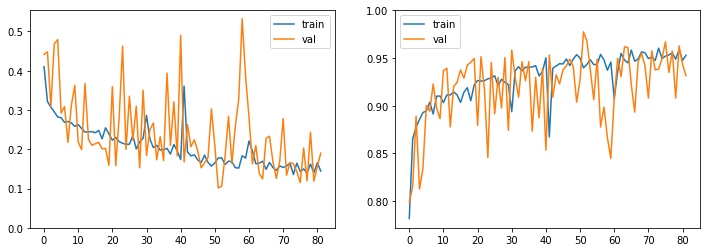

In [27]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6052 - accuracy: 0.6544 - precision: 0.8744 - recall: 0.6353 - f1: 0.7206 - specificity: 0.7123 - negative_predictive_value: 0.4127 - matthews_correlation_coefficient: 0.3152 - val_loss: 0.7285 - val_accuracy: 0.6114 - val_precision: 0.8754 - val_recall: 0.5221 - val_f1: 0.6465 - val_specificity: 0.8284 - val_negative_predictive_value: 0.4035 - val_matthews_correlation_coefficient: 0.3109

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31093, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_19-00_23_33.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5732 - accuracy: 0.6746 - precision: 0.8828 - recall: 0.6398 - f1: 0.7343 - specificity: 0.7683 - negative_predictive_value: 0.4378 - matthews_correlation_coefficient: 0.3608 - val_loss: 0.7091 - val_accuracy: 0.5950 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5388 - accuracy: 0.7041 - precision: 0.8999 - recall: 0.6798 - f1: 0.7688 - specificity: 0.7783 - negative_predictive_value: 0.4659 - matthews_correlation_coefficient: 0.4080 - val_loss: 0.5851 - val_accuracy: 0.6834 - val_precision: 0.8598 - val_recall: 0.6411 - val_f1: 0.7292 - val_specificity: 0.7642 - val_negative_predictive_value: 0.4559 - val_matthews_correlation_coefficient: 0.3561

Epoch 00015: val_matthews_correlation_coefficient improved from 0.34498 to 0.35614, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_19-00_23_33.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5360 - accuracy: 0.7080 - precision: 0.8984 - recall: 0.6828 - f1: 0.7711 - specificity: 0.7752 - negative_predictive_value: 0.4643 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.5611 - val_accuracy: 0.7016 - val_precision: 0.8324 - val_recall: 0.7004 - val_f1: 0.7558 - val_speci


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.35614
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5246 - accuracy: 0.7184 - precision: 0.9025 - recall: 0.6941 - f1: 0.7789 - specificity: 0.7802 - negative_predictive_value: 0.4787 - matthews_correlation_coefficient: 0.4247 - val_loss: 0.5857 - val_accuracy: 0.6687 - val_precision: 0.8601 - val_recall: 0.6187 - val_f1: 0.7144 - val_specificity: 0.7696 - val_negative_predictive_value: 0.4426 - val_matthews_correlation_coefficient: 0.3413

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.35614
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5209 - accuracy: 0.7210 - precision: 0.8996 - recall: 0.7010 - f1: 0.7828 - specificity: 0.7791 - negative_predictive_value: 0.4818 - matthews_correlation_coefficient: 0.4255 - val_loss: 0.6002 - val_accuracy: 0.6713 - val_precision: 0.8536 - val_recall: 0.6284 - val_f1: 0.7188 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5113 - accuracy: 0.7252 - precision: 0.8977 - recall: 0.6994 - f1: 0.7814 - specificity: 0.7886 - negative_predictive_value: 0.4914 - matthews_correlation_coefficient: 0.4336 - val_loss: 0.6617 - val_accuracy: 0.6409 - val_precision: 0.8647 - val_recall: 0.5726 - val_f1: 0.6829 - val_specificity: 0.8010 - val_negative_predictive_value: 0.4217 - val_matthews_correlation_coefficient: 0.3254

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36512
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5207 - accuracy: 0.7089 - precision: 0.8982 - recall: 0.6737 - f1: 0.7636 - specificity: 0.7886 - negative_predictive_value: 0.4683 - matthews_correlation_coefficient: 0.4167 - val_loss: 0.5261 - val_accuracy: 0.7173 - val_precision: 0.8400 - val_recall: 0.7175 - val_f1: 0.7685 - val_specificity: 0.6765 - val_negative_predictive_value: 0.4897 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5144 - accuracy: 0.7204 - precision: 0.8998 - recall: 0.6883 - f1: 0.7756 - specificity: 0.8059 - negative_predictive_value: 0.4778 - matthews_correlation_coefficient: 0.4305 - val_loss: 0.5834 - val_accuracy: 0.6800 - val_precision: 0.8500 - val_recall: 0.6431 - val_f1: 0.7270 - val_specificity: 0.7344 - val_negative_predictive_value: 0.4501 - val_matthews_correlation_coefficient: 0.3352

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.36512
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4964 - accuracy: 0.7299 - precision: 0.9109 - recall: 0.7029 - f1: 0.7885 - specificity: 0.8011 - negative_predictive_value: 0.4920 - matthews_correlation_coefficient: 0.4498 - val_loss: 0.5545 - val_accuracy: 0.6860 - val_precision: 0.8648 - val_recall: 0.6404 - val_f1: 0.7305 - val_specificity: 0.7689 - val_negative_predictive_value: 0.4571 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.37719
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4830 - accuracy: 0.7460 - precision: 0.9030 - recall: 0.7232 - f1: 0.7991 - specificity: 0.7959 - negative_predictive_value: 0.5068 - matthews_correlation_coefficient: 0.4581 - val_loss: 0.5899 - val_accuracy: 0.6730 - val_precision: 0.8775 - val_recall: 0.6082 - val_f1: 0.7122 - val_specificity: 0.8072 - val_negative_predictive_value: 0.4491 - val_matthews_correlation_coefficient: 0.3665

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.37719
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4913 - accuracy: 0.7338 - precision: 0.9136 - recall: 0.7086 - f1: 0.7943 - specificity: 0.8046 - negative_predictive_value: 0.4985 - matthews_correlation_coefficient: 0.4584 - val_loss: 0.5162 - val_accuracy: 0.7112 - val_precision: 0.8463 - val_recall: 0.6999 - val_f1: 0.7605 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.37926
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4788 - accuracy: 0.7395 - precision: 0.9205 - recall: 0.7118 - f1: 0.7969 - specificity: 0.8163 - negative_predictive_value: 0.4999 - matthews_correlation_coefficient: 0.4691 - val_loss: 0.5752 - val_accuracy: 0.6904 - val_precision: 0.8495 - val_recall: 0.6627 - val_f1: 0.7386 - val_specificity: 0.7178 - val_negative_predictive_value: 0.4599 - val_matthews_correlation_coefficient: 0.3417

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.37926
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4773 - accuracy: 0.7443 - precision: 0.9143 - recall: 0.7247 - f1: 0.8037 - specificity: 0.8115 - negative_predictive_value: 0.5140 - matthews_correlation_coefficient: 0.4766 - val_loss: 0.5729 - val_accuracy: 0.6713 - val_precision: 0.8583 - val_recall: 0.6234 - val_f1: 0.7162 - val_spe

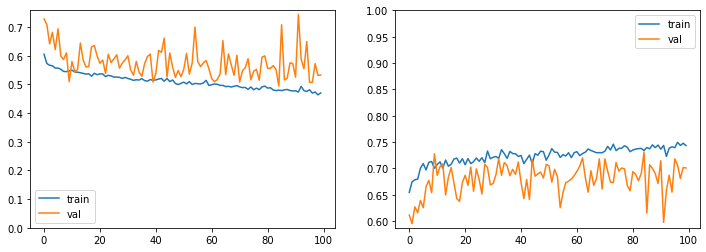

In [28]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5264 - accuracy: 0.8193 - precision: 0.9973 - recall: 0.8218 - f1: 0.8960 - specificity: 0.1448 - negative_predictive_value: 0.0218 - matthews_correlation_coefficient: 0.0474 - val_loss: 0.2728 - val_accuracy: 0.8604 - val_precision: 0.9991 - val_recall: 0.8637 - val_f1: 0.9249 - val_specificity: 0.1757 - val_negative_predictive_value: 0.0384 - val_matthews_correlation_coefficient: 0.0717

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07175, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_19-00_38_31.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3217 - accuracy: 0.8098 - precision: 0.9991 - recall: 0.8105 - f1: 0.8914 - specificity: 0.1897 - negative_predictive_value: 0.0421 - matthews_correlation_coefficient: 0.0772 - val_loss: 0.2760 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2253 - accuracy: 0.8640 - precision: 0.9998 - recall: 0.8609 - f1: 0.9236 - specificity: 0.2138 - negative_predictive_value: 0.0502 - matthews_correlation_coefficient: 0.0950 - val_loss: 0.4361 - val_accuracy: 0.8092 - val_precision: 1.0000 - val_recall: 0.8128 - val_f1: 0.8950 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0370 - val_matthews_correlation_coefficient: 0.0738

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.08322
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2013 - accuracy: 0.8664 - precision: 1.0000 - recall: 0.8662 - f1: 0.9274 - specificity: 0.2207 - negative_predictive_value: 0.0472 - matthews_correlation_coefficient: 0.0941 - val_loss: 0.3235 - val_accuracy: 0.8682 - val_precision: 1.0000 - val_recall: 0.8705 - val_f1: 0.9294 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0452 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.08856
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2625 - accuracy: 0.8659 - precision: 0.9998 - recall: 0.8661 - f1: 0.9269 - specificity: 0.2138 - negative_predictive_value: 0.0546 - matthews_correlation_coefficient: 0.0990 - val_loss: 0.3830 - val_accuracy: 0.8352 - val_precision: 1.0000 - val_recall: 0.8383 - val_f1: 0.9105 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0399 - val_matthews_correlation_coefficient: 0.0776

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.08856
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1944 - accuracy: 0.8720 - precision: 1.0000 - recall: 0.8719 - f1: 0.9307 - specificity: 0.2345 - negative_predictive_value: 0.0562 - matthews_correlation_coefficient: 0.1057 - val_loss: 0.2395 - val_accuracy: 0.8829 - val_precision: 0.9991 - val_recall: 0.8858 - val_f1: 0.9377 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.08856
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1942 - accuracy: 0.8751 - precision: 1.0000 - recall: 0.8750 - f1: 0.9325 - specificity: 0.2138 - negative_predictive_value: 0.0567 - matthews_correlation_coefficient: 0.1020 - val_loss: 0.2709 - val_accuracy: 0.8751 - val_precision: 1.0000 - val_recall: 0.8773 - val_f1: 0.9333 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0465 - val_matthews_correlation_coefficient: 0.0846

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.08856
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1744 - accuracy: 0.8881 - precision: 1.0000 - recall: 0.8880 - f1: 0.9399 - specificity: 0.2414 - negative_predictive_value: 0.0618 - matthews_correlation_coefficient: 0.1141 - val_loss: 0.2222 - val_accuracy: 0.8864 - val_precision: 1.0000 - val_recall: 0.8885 - val_f1: 0.9396 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1889 - accuracy: 0.8818 - precision: 0.9998 - recall: 0.8819 - f1: 0.9364 - specificity: 0.2276 - negative_predictive_value: 0.0631 - matthews_correlation_coefficient: 0.1097 - val_loss: 0.2711 - val_accuracy: 0.8768 - val_precision: 1.0000 - val_recall: 0.8791 - val_f1: 0.9342 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0483 - val_matthews_correlation_coefficient: 0.0863

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.09181
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2272 - accuracy: 0.8601 - precision: 0.9997 - recall: 0.8569 - f1: 0.9209 - specificity: 0.2069 - negative_predictive_value: 0.0523 - matthews_correlation_coefficient: 0.0931 - val_loss: 0.4048 - val_accuracy: 0.7988 - val_precision: 1.0000 - val_recall: 0.8026 - val_f1: 0.8885 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0363 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1863 - accuracy: 0.8798 - precision: 0.9997 - recall: 0.8798 - f1: 0.9350 - specificity: 0.2207 - negative_predictive_value: 0.0563 - matthews_correlation_coefficient: 0.1006 - val_loss: 0.2449 - val_accuracy: 0.8656 - val_precision: 1.0000 - val_recall: 0.8682 - val_f1: 0.9278 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0528 - val_matthews_correlation_coefficient: 0.0895

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.09181
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1829 - accuracy: 0.8907 - precision: 0.9998 - recall: 0.8908 - f1: 0.9414 - specificity: 0.2034 - negative_predictive_value: 0.0586 - matthews_correlation_coefficient: 0.1018 - val_loss: 0.5121 - val_accuracy: 0.8300 - val_precision: 1.0000 - val_recall: 0.8332 - val_f1: 0.9072 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0410 - val_matthews_correlation_coefficie

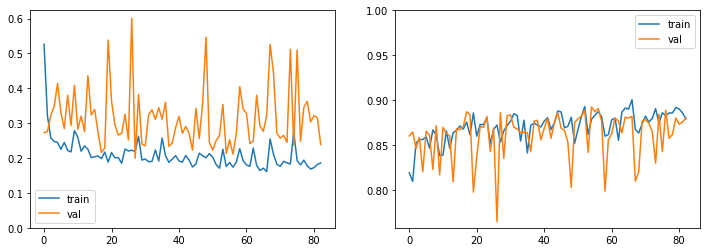

In [29]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [30]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [31]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_18-20_00_23.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_18-20_15_13.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_18-20_28_15.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_18-20_38_12.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_18-20_53_01.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_18-21_07_54.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_18-21_14_58.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_18-21_26_45.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_18-21_39_35.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_18-21_54_25.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_18-22_09_19.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_18-22_24_13.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_18-22_33_24.h5'


In [32]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [33]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [34]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5')

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [35]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\AR_FDB_m-013-17.png
1 of 1


[array([[0.9997547]], dtype=float32),
 array([[0.6149203]], dtype=float32),
 array([[0.98830765]], dtype=float32),
 array([[0.98410183]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9171152]], dtype=float32),
 array([[0.57651633]], dtype=float32),
 array([[0.7157077]], dtype=float32),
 array([[0.5758669]], dtype=float32),
 array([[0.69585174]], dtype=float32),
 array([[0.9092646]], dtype=float32),
 array([[0.5616114]], dtype=float32),
 array([[0.9999975]], dtype=float32),
 array([[0.98578423]], dtype=float32),
 array([[0.96653694]], dtype=float32),
 array([[0.36451632]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.55288583]], dtype=float32),
 array([[0.9999976]], dtype=float32),
 array([[0.99966943]], dtype=float32),
 array([[0.34374452]], dtype=float32),
 array([[1.]], dtype=float32)]